<a href="https://colab.research.google.com/github/PRaezUC3M/cohort_selection/blob/master/Statistical_Significance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Load the train and test csv files**
This functions load the data and generate the different datasets from the given csv files. 

In [0]:
import pandas as pd
import numpy as np

SST_HOME='drive/My Drive/Colab Notebooks/CohortSelection/'
path_train=SST_HOME+'data/train/train.csv'
path_test=SST_HOME+'data/test/test.csv'

def load(path):
  
  df = pd.read_csv(path,header=0, delimiter="\t", quoting=3)

  categories=df.columns[2:]
  idFiles = df[['IDFILE']].as_matrix().tolist()

  texts = df[['TEXT']].as_matrix()
  X = [x[0].strip() for x in texts.tolist()]

  #we only keep the columns with the categories.
  Y = df.drop(['IDFILE', 'TEXT'], axis=1).as_matrix()


  print(path,'dataset loaded')
  
  return X, Y, categories, idFiles


train_x, train_y, CATEGORIES, _ = load(path_train)
test_x, test_y, _, IDFILES = load(path_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


drive/My Drive/Colab Notebooks/CohortSelection/data/train/train.csv dataset loaded
drive/My Drive/Colab Notebooks/CohortSelection/data/test/test.csv dataset loaded


# **Tokenize the dataset and use the word embeddings**

This shows the set of different words ordered by frequency. *tokenizer.word_index*

The text is tokenized and cleaned of stop-words as well as punctuation signs. Also the numbers are substituted by a token "nmbr"

We crop the beggining of the examples because it is the date when they
were written down.

Finally, and after being tokenized, the different sentences are padded to match the maximum length.

max_length == 7813 it is really a huge vector because we have to pad
it afterwards, in order to get it into the CNN

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words('english')
# Define maximum word length
MAX_WORDS = 5000
# Defined from the dataset itself.
DATE_LENGTH = 23
# Thus, we initialize the maximum word length as
max_length = 5000

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# We are using this function to clean the test set
def tokenize_clean_text(text, tokenizer=None, max_length=None, 
                        max_words=MAX_WORDS, date_length=DATE_LENGTH):
  """
  This function is in charge of tokenizing the text it is given. It also cleans
  the text from stop-words, punctuation, and gives a special token to numbers.
  
  :param text: The texts to tokenize in a bidimensional python array.
  
  :returns: The tokenized and cleaned text in a bidimensional python array.
            The tokenizer used to preprocess the text.
            The maximum length used for padding.
  """  
  # Consider to stemm or lemmatize the text 
  
  cropped_date_text = [sentence[date_length:] for sentence in text]

  if max_length == None:
    # We get the maximum token length by splitting by spaces
    max_length = max([len(sentence[date_length:].split(" ")) for sentence in cropped_date_text])
    
  # We remove the numbers
  cropped_date_numbers_text = [" ".join([word if not word.isdigit() else ""
                                for word in sentence.split()])
                               for sentence in cropped_date_text]
  
  # Delete stopwords as well as every word less than 3 chars.
  cropped_date_numbers_stopw_text = [" ".join([word if not (word in stop_words or len(word) <= 3) else ""
                                      for word in sentence.split()])
                                     for sentence in cropped_date_numbers_text]
  
  if tokenizer is None:
    tokenizer = Tokenizer(num_words=MAX_WORDS) # They use 5k words too
    tokenizer.fit_on_texts(cropped_date_numbers_stopw_text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(cropped_date_numbers_stopw_text)
  
  # Now we return the padded the sequences.
  return pad_sequences(tokenized_text, max_length), tokenizer, max_length
  

In [0]:
train_x_token, tokenizer, max_length = tokenize_clean_text(train_x, max_length=max_length)
  
test_x_token, _, _ = tokenize_clean_text(test_x, tokenizer, max_length)
assert len(train_x_token) == len(train_x)
assert len(test_x_token) == len(test_x)

Load Models and get Predictions
===========================

In [0]:
from keras.models import load_model
from keras import backend as K

In [0]:
# First, we load all the representative models we were using
!ls 'drive/My Drive/Colab Notebooks/CohortSelection/DL/models/stat models/cnn-rnn' 

'Copia de load_embeddings_t_False_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128'
'Copia de load_embeddings_t_False_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_None_batch_size_128'
'Copia de load_embeddings_t_True_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128'
'Copia de load_embeddings_t_True_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_None_batch_size_128'


In [0]:
SST_HOME='drive/My Drive/Colab Notebooks/CohortSelection/'
MODELS_HOME='drive/My Drive/Colab Notebooks/CohortSelection/DL/models/stat models/'

In [0]:
MODEL_PATHS = [MODELS_HOME + 'cnn/' + 'Copia de oversampling_False_load_embeddings_t_False_num_classes_13_embeddings_size_200_conv_size_128_conv_filter_10_dropout_0.1_fnn_size_None_batch_size_32',
               MODELS_HOME + 'cnn/' + 'Copia de oversampling_False_load_embeddings_t_False_num_classes_13_embeddings_size_200_conv_size_128_conv_filter_10_dropout_0.1_fnn_size_64-13_batch_size_32',
               MODELS_HOME + 'cnn/' + 'Copia de oversampling_False_load_embeddings_t_True_num_classes_13_embeddings_size_200_conv_size_128_conv_filter_10_dropout_0.1_fnn_size_None_batch_size_32',
               MODELS_HOME + 'cnn/' + 'Copia de oversampling_False_load_embeddings_t_True_num_classes_13_embeddings_size_200_conv_size_128_conv_filter_10_dropout_0.1_fnn_size_64-13_batch_size_32',
               MODELS_HOME + 'vdcnn/' + 'Copia de oversampling_False_load_embeddings_t_False_num_classes_13_embeddings_size_200_conv_size_64-64-128-128-256-256_conv_filter_3_dropout_0.45_fnn_size_None_batch_size_32',
               MODELS_HOME + 'vdcnn/' + 'Copia de oversampling_False_load_embeddings_t_False_num_classes_13_embeddings_size_200_conv_size_64-64-128-128-256-256_conv_filter_3_dropout_0.45_fnn_size_256-128-128-64_batch_size_32',
               MODELS_HOME + 'vdcnn/' + 'Copia de oversampling_False_load_embeddings_t_True_num_classes_13_embeddings_size_200_conv_size_64-64-128-128-256-256_conv_filter_3_dropout_0.45_fnn_size_None_batch_size_32',
               MODELS_HOME + 'vdcnn/' + 'Copia de oversampling_False_load_embeddings_t_True_num_classes_13_embeddings_size_200_conv_size_64-64-128-128-256-256_conv_filter_3_dropout_0.45_fnn_size_256-128-128-64_batch_size_32',
               MODELS_HOME + 'rnn/' +'Copia de tfid_load_embeddings_False_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_None_batch_size_128',
               MODELS_HOME + 'rnn/' +'Copia de tfid_load_embeddings_False_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128',
               MODELS_HOME + 'rnn/' +'Copia de tfid_load_embeddings_True_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_None_batch_size_128',
               MODELS_HOME + 'rnn/' +'Copia de tfid_load_embeddings_True_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128',
               MODELS_HOME + 'cnn-rnn/' + 'Copia de load_embeddings_t_False_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_None_batch_size_128',
               MODELS_HOME + 'cnn-rnn/' + 'Copia de load_embeddings_t_False_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128',
               MODELS_HOME + 'cnn-rnn/' + 'Copia de load_embeddings_t_True_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_None_batch_size_128',
               MODELS_HOME + 'cnn-rnn/' + 'Copia de load_embeddings_t_True_num_classes_None_embeddings_size_200_conv_size_128-128_conv_filter_5_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128',
               MODELS_HOME + 'rnn/' +'Copia de renewed_tfid_load_embeddings_False_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128',
               MODELS_HOME + 'rnn/' +'Copia de renewed_tfid_load_embeddings_True_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128',]


clf = ["cnn + ran", "cnn + ran + fnn", "cnn + pre", "cnn + pre + fnn", "vdcnn + ran", "vdcnn + ran + fnn", "vdcnn + pre", "vdcnn + pre + fnn", 
       "rnn + ran", "rnn + ran + fnn", "rnn + pre", "rnn + pre + fnn", "cnn-rnn + ran", "cnn-rnn + ran + fnn", "cnn-rnn + pre", "cnn-rnn + pre + fnn",
       "new rnn + ran + fnn", "new rnn + pre + fnn"]

In [0]:
# CRDNN, RNN, VDCNN, CNN

In [0]:
# Then, we create the label distribution
predictions_list = []
no_logits_predictions = []
for model in MODEL_PATHS:
  try:
    net_model = load_model(model)
  except ValueError:
    print("The model {} was not loaded correctly".format(name))
    continue
    
  predictions = net_model.predict(test_x_token)
  no_logits_predictions.append(predictions)
  predictions = np.array([[0 if value < 0.5 else 1 for value in prediction] for prediction in predictions])
  predictions_list.append(predictions)
  
  # Release memory
  K.clear_session()

W0617 12:34:43.006796 140209375029120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 12:34:43.097182 140209375029120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 12:34:43.135130 140209375029120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 12:34:43.136757 140209375029120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0617 12:34:43.150444

Here, we are turning the labels into numbers as if they were binary noation with the right-most bit as the most representative one (instead of the leftmost).

It does not matter as we apply the same procedure to all predictions obtained from the models.

In [0]:
def label_to_int(predictions_list):
  np_l = []
  for l in predictions_list:
    new_p = []
    for p in l:
      aux = 0
      for i, e in enumerate(p):
        aux += e * 2 ** i
      new_p.append(aux)
    np_l.append(new_p)
  
  return np_l


def label_to_str(predictions_list):
  np_l = label_to_int(predictions_list)
  sp_l = []
  for p in np_l:
    aux_l = []
    for l in p:
      aux_l.append(chr(l))
      
    sp_l.append(aux_l)
   
  return sp_l
  
  
def concat_testings(predictions_list):
  cp_l = []
  for l in predictions_list: 
    cp_l.append(np.concatenate(l))
    
  return cp_l

# cp_l = concat_testings(predictions_list)
# sp_l = label_to_str(predictions_list)
np_l = label_to_int(predictions_list)


In [0]:
x = [print(p) for p in np_l] # Int representation of the predicted labels

[2733, 681, 681, 681, 2731, 2733, 2729, 685, 649, 649, 681, 681, 711, 681, 685, 681, 681, 685, 2733, 681, 649, 681, 743, 751, 655, 2733, 681, 649, 649, 679]
[685, 685, 673, 681, 687, 685, 2733, 655, 641, 641, 2733, 685, 647, 655, 685, 2733, 2729, 685, 685, 687, 2721, 685, 687, 687, 655, 2733, 685, 673, 673, 677]
[653, 685, 2729, 649, 687, 685, 2733, 653, 681, 649, 2733, 2729, 751, 2731, 2733, 681, 2731, 685, 653, 2731, 681, 649, 647, 687, 687, 2733, 681, 681, 649, 677]
[681, 2733, 2729, 683, 2733, 2733, 681, 653, 2729, 681, 2729, 2729, 717, 683, 2733, 681, 683, 685, 685, 2729, 681, 2697, 711, 751, 687, 2733, 2729, 2729, 681, 751]
[685, 681, 649, 681, 2729, 681, 681, 685, 649, 649, 681, 681, 645, 681, 685, 681, 2729, 685, 685, 681, 649, 681, 645, 679, 647, 681, 649, 649, 649, 645]
[681, 681, 681, 681, 681, 681, 681, 685, 681, 681, 681, 681, 685, 681, 685, 681, 681, 685, 681, 681, 681, 681, 685, 681, 685, 681, 681, 681, 681, 685]
[685, 685, 649, 681, 685, 685, 681, 685, 649, 649, 681, 68

In [0]:
!pip install distance
import distance

first_distance = distance.hamming(predictions_list[9], predictions_list[11])
second_distance = distance.hamming(predictions_list[-2], predictions_list[-1])

print("First: {}\nSecond: {}".format(first_distance, second_distance))

     |████████████████████████████████| 184kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance
First: [0 1 7 0 0 3 0 0 0 0 0 2 0]
Second: [ 0  0 13  0  0 20  0  0  0  0  0  2  0]


In [0]:
#[649, 681, 681, 685, 681, 685, 685, 681, 681, 681, 685, 685, 685, 685, 649, 681, 685, 687, 681, 685, 685, 649, 681, 685, 2733, 685, 685, 681, 685, 2733]
#[681, 685, 681, 681, 681, 681, 681, 681, 681, 681, 685, 685, 685, 685, 681, 685, 685, 681, 681, 685, 685, 681, 681, 685, 685, 685, 681, 681, 685, 685]

In [0]:
#[649, 649, 649, 649, 649, 685, 649, 649, 649, 649, 685, 653, 685, 649, 649, 649, 649, 685, 653, 685, 685, 649, 649, 685, 2733, 685, 649, 649, 653, 2733]
#[681, 685, 685, 685, 685, 685, 685, 685, 681, 685, 685, 685, 685, 685, 681, 685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 681, 685, 685]

Evaluation of Experiments
=====================

For more info refer to: 

https://www.pydoc.io/pypi/scikit-posthocs-0.3.7/autoapi/_posthocs/index.html

In [0]:
!pip install scikit-posthocs
import scikit_posthocs as sp

# Friedman

In [0]:
import scipy.stats as ss
import itertools
import matplotlib.pyplot as plt

In [0]:
# list of possible models
clf = ["cnn + ran", "cnn + ran + fnn", "cnn + pre", "cnn + pre + fnn", "vdcnn + ran", "vdcnn + ran + fnn", "vdcnn + pre", "vdcnn + pre + fnn", 
       "rnn + ran", "rnn + ran + fnn", "rnn + pre", "rnn + pre + fnn", "hybrid + ran", "hybrid + ran + fnn", "hybrid + pre", "hybrid + pre + fnn",
       "new rnn + ran + fnn", "new rnn + pre + fnn"]
def friedman_test(x, clf=clf):
  """
  Performs the friedman test.
  
  Params:
    x: Arrays of measurements. All of the arrays must have the same number of elements. At least 3 sets of measurements must be given.
    clf: The labels for the measruements
    
  Returns:
    A similarity array.
  """
  # all one-to-one combinations
  models_number = len(x)
  combinations = list(itertools.combinations(range(models_number), 2))
  assert len(clf) == models_number

  similarity = np.ones((models_number, models_number))
  # run tests
  for pair in combinations:
    # print("PAIR: {}  {}".format(clf[pair[0]], clf[pair[1]]))
    arrays= np.stack([x[pair[0]], x[pair[1]]])
    if np.array_equal(arrays[0], arrays[1]):
      #print("Equal Pair: {}".format(pair))
      continue
    #p_value = ss.wilcoxon(arrays[0], arrays[1])[1]
    p_value = ss.friedmanchisquare(*arrays.T)[1]
    # print("P-value: {}".format(p_value))
    if p_value is not np.nan:
      similarity[pair[0], pair[1]] = p_value
      similarity[pair[1], pair[0]] = p_value
      
  similarity = pd.DataFrame(data=similarity, columns=clf, index=clf)
  return similarity

def plot_significance_matrix(similarity, clf=clf):
  
  fig, ax = plt.subplots()

  im, cbar = heatmap(similarity, clf, clf, ax=ax,
                     cmap="YlGn", cbarlabel="Friemdan P-Value")

  fig.set_size_inches(18.5, 10.5)
  fig.tight_layout()
  # plt.save()
  plt.show()

In [0]:
predictions_list_list = [p.tolist() for p in predictions_list]
predictions_list_list_concat = []
for p in predictions_list_list:
  aux = []
  for px in p:
    aux += px
  predictions_list_list_concat.append(aux)
len(predictions_list_list_concat)

18

In [0]:
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
similarity = friedman_test(np_l)
similarity
# similarity_pl = friedman_test(predictions_list_list)
# similarity_pl2 = friedman_test(predictions_list_list_concat)
# similarity_str = friedman_test(sp_l)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.070197,0.189241,0.251794,0.038242,0.342996,0.022721,0.037677,0.792509,0.687166,0.264145,0.837937,0.538395,0.278701,0.549200,0.724778,0.430784,0.353753
cnn + ran + fnn,0.070197,1.000000,0.093414,0.300452,0.081866,0.858351,0.178929,0.488758,0.346789,0.367861,0.473271,0.197744,0.559378,0.449135,0.291443,0.901660,0.325834,0.203242
cnn + pre,0.189241,0.093414,1.000000,0.065873,0.165637,0.559692,0.090756,0.430641,0.330585,0.126453,0.431491,0.085029,0.145204,0.152950,0.260528,0.630164,0.186514,0.427813
cnn + pre + fnn,0.251794,0.300452,0.065873,1.000000,0.453833,0.595075,0.246828,0.253833,0.622400,0.575722,0.767862,0.494606,0.169911,0.079555,0.453956,0.405938,0.293424,0.691097
vdcnn + ran,0.038242,0.081866,0.165637,0.453833,1.000000,0.748263,0.033949,0.383921,0.751510,0.850011,0.683829,0.770732,0.673442,0.741033,0.447300,0.688658,0.849570,0.561692
vdcnn + ran + fnn,0.342996,0.858351,0.559692,0.595075,0.748263,1.000000,0.258103,0.024158,0.308621,0.239872,0.166877,0.528904,0.339191,0.431411,0.279654,0.389831,0.154625,0.488026
vdcnn + pre,0.022721,0.178929,0.090756,0.246828,0.033949,0.258103,1.000000,0.020517,0.607094,0.239611,0.477577,0.294751,0.738657,0.585687,0.857569,0.694995,0.171171,0.345296
vdcnn + pre + fnn,0.037677,0.488758,0.430641,0.253833,0.383921,0.024158,0.020517,1.000000,0.734049,0.341015,0.226737,0.374317,0.413312,0.263713,0.529911,0.489859,0.053106,0.502308
rnn + ran,0.792509,0.346789,0.330585,0.622400,0.751510,0.308621,0.607094,0.734049,1.000000,0.045823,0.148270,0.226349,0.096989,0.228686,0.390486,0.235989,0.119914,0.100600
rnn + ran + fnn,0.687166,0.367861,0.126453,0.575722,0.850011,0.239872,0.239611,0.341015,0.045823,1.000000,0.175188,0.033600,0.466535,0.222669,0.444009,0.267225,0.009396,0.054574


In [0]:
similarity

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.070197,0.189241,0.251794,0.038242,0.342996,0.022721,0.037677,0.792509,0.687166,0.264145,0.837937,0.538395,0.278701,0.549200,0.724778,0.430784,0.353753
cnn + ran + fnn,0.070197,1.000000,0.093414,0.300452,0.081866,0.858351,0.178929,0.488758,0.346789,0.367861,0.473271,0.197744,0.559378,0.449135,0.291443,0.901660,0.325834,0.203242
cnn + pre,0.189241,0.093414,1.000000,0.065873,0.165637,0.559692,0.090756,0.430641,0.330585,0.126453,0.431491,0.085029,0.145204,0.152950,0.260528,0.630164,0.186514,0.427813
cnn + pre + fnn,0.251794,0.300452,0.065873,1.000000,0.453833,0.595075,0.246828,0.253833,0.622400,0.575722,0.767862,0.494606,0.169911,0.079555,0.453956,0.405938,0.293424,0.691097
vdcnn + ran,0.038242,0.081866,0.165637,0.453833,1.000000,0.748263,0.033949,0.383921,0.751510,0.850011,0.683829,0.770732,0.673442,0.741033,0.447300,0.688658,0.849570,0.561692
vdcnn + ran + fnn,0.342996,0.858351,0.559692,0.595075,0.748263,1.000000,0.258103,0.024158,0.308621,0.239872,0.166877,0.528904,0.339191,0.431411,0.279654,0.389831,0.154625,0.488026
vdcnn + pre,0.022721,0.178929,0.090756,0.246828,0.033949,0.258103,1.000000,0.020517,0.607094,0.239611,0.477577,0.294751,0.738657,0.585687,0.857569,0.694995,0.171171,0.345296
vdcnn + pre + fnn,0.037677,0.488758,0.430641,0.253833,0.383921,0.024158,0.020517,1.000000,0.734049,0.341015,0.226737,0.374317,0.413312,0.263713,0.529911,0.489859,0.053106,0.502308
rnn + ran,0.792509,0.346789,0.330585,0.622400,0.751510,0.308621,0.607094,0.734049,1.000000,0.045823,0.148270,0.226349,0.096989,0.228686,0.390486,0.235989,0.119914,0.100600
rnn + ran + fnn,0.687166,0.367861,0.126453,0.575722,0.850011,0.239872,0.239611,0.341015,0.045823,1.000000,0.175188,0.033600,0.466535,0.222669,0.444009,0.267225,0.009396,0.054574


In [0]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


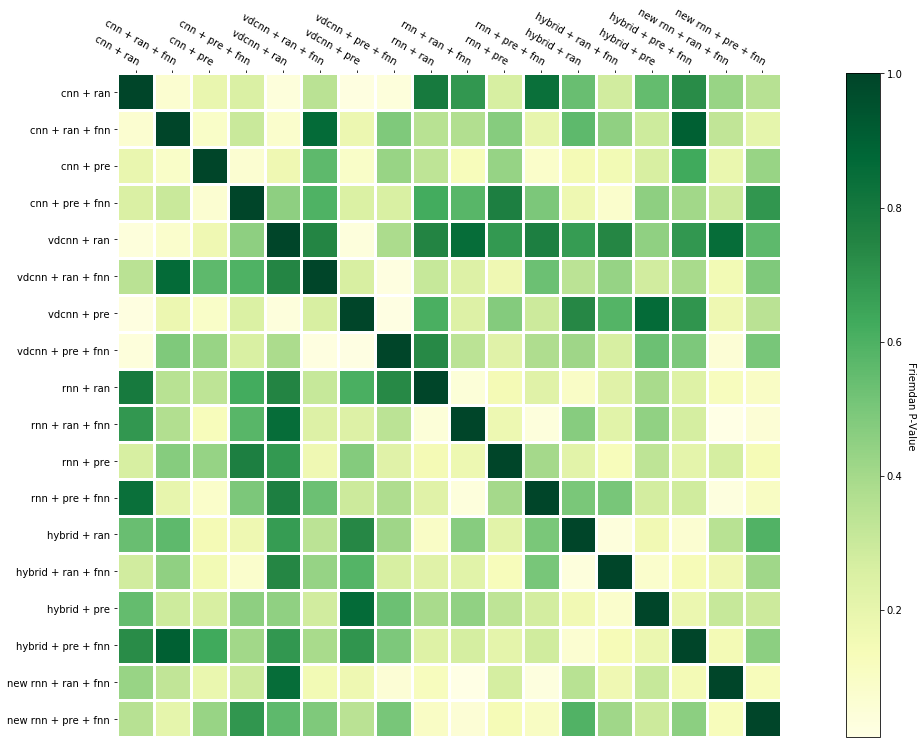

In [0]:
fig, ax = plt.subplots()

im, cbar = heatmap(similarity, clf, clf, ax=ax,
                   cmap="YlGn", cbarlabel="Friemdan P-Value")

fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
# plt.save()
plt.show()

Nemenyi-Friedman
===============
Calculate pairwise comparisons using Nemenyi post-hoc test for unreplicated blocked data.

This test is usually conducted post-hoc after significant results of the Friedman’s test. 

The statistics refer to upper quantiles of the studentized range distribution (Tukey).


In [0]:
x = np.array(np_l).transpose()
sp.posthoc_nemenyi_friedman(x)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.900000,0.900000,0.350772,0.626860,0.900000,0.900000,0.900000,0.012601,0.900000,0.102720,0.900000,0.900000,0.900000,0.900000,0.001000,0.272672,0.900000
1,0.900000,-1.000000,0.900000,0.887997,0.138169,0.900000,0.900000,0.900000,0.162758,0.900000,0.006510,0.900000,0.900000,0.769299,0.900000,0.001000,0.027825,0.900000
2,0.900000,0.900000,-1.000000,0.824693,0.177805,0.900000,0.900000,0.900000,0.125005,0.900000,0.009537,0.900000,0.900000,0.832607,0.900000,0.001000,0.038791,0.900000
3,0.350772,0.887997,0.824693,-1.000000,0.001000,0.018078,0.016539,0.302372,0.900000,0.595211,0.001000,0.302372,0.125005,0.005905,0.900000,0.001000,0.001000,0.900000
4,0.626860,0.138169,0.177805,0.001000,-1.000000,0.900000,0.900000,0.674342,0.001000,0.386511,0.900000,0.674342,0.900000,0.900000,0.064604,0.152646,0.900000,0.018893
5,0.900000,0.900000,0.900000,0.018078,0.900000,-1.000000,0.900000,0.900000,0.001000,0.900000,0.713908,0.900000,0.900000,0.900000,0.785127,0.001401,0.900000,0.547730
6,0.900000,0.900000,0.900000,0.016539,0.900000,0.900000,-1.000000,0.900000,0.001000,0.900000,0.729736,0.900000,0.900000,0.900000,0.769299,0.001556,0.900000,0.531903
7,0.900000,0.900000,0.900000,0.302372,0.674342,0.900000,0.900000,-1.000000,0.009537,0.900000,0.125005,0.900000,0.900000,0.900000,0.900000,0.001000,0.317539,0.900000
8,0.012601,0.162758,0.125005,0.900000,0.001000,0.001000,0.001000,0.009537,-1.000000,0.043733,0.001000,0.009537,0.002140,0.001000,0.302372,0.001000,0.001000,0.555641
9,0.900000,0.900000,0.900000,0.595211,0.386511,0.900000,0.900000,0.900000,0.043733,-1.000000,0.034316,0.900000,0.900000,0.900000,0.900000,0.001000,0.114257,0.900000


Those are the p-values for the hypothesis. We could take an alpha value of 0.05, having a 95% of coverage.

In this case, the null hypothesis can't be rejected, so the distributions are taken as if they were part of the same one. The most different one is the one given by the CRDNN model, which was known for over-fitting the results.

Conover-Friedman
===============
Calculate pairwise comparisons using Conover post-hoc test for unreplicated blocked data. 

This test is usually conducted post-hoc after significant results of the Friedman test.

The statistics refer to the Student t distribution.



In [0]:
x = np.array(np_l).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000e+00,4.100300e-01,4.690423e-01,4.757171e-03,1.572403e-02,2.831671e-01,2.721344e-01,9.402782e-01,7.004722e-05,7.172838e-01,8.379827e-04,9.402782e-01,6.530879e-01,1.699922e-01,2.721344e-01,2.957968e-08,3.215706e-03,1.410707e-01
1,4.100300e-01,-1.000000e+00,9.204290e-01,4.482856e-02,1.240574e-03,5.815497e-02,5.493834e-02,3.688249e-01,1.535367e-03,6.441105e-01,3.374381e-05,3.688249e-01,2.031598e-01,2.835731e-02,7.835485e-01,2.531979e-10,1.723621e-04,5.162275e-01
2,4.690423e-01,9.204290e-01,-1.000000e+00,3.524670e-02,1.742031e-03,7.262974e-02,6.875901e-02,4.243528e-01,1.089830e-03,7.172838e-01,5.138578e-05,4.243528e-01,2.408223e-01,3.633939e-02,7.079762e-01,4.636653e-10,2.536042e-04,4.538626e-01
3,4.757171e-03,4.482856e-02,3.524670e-02,-1.000000e+00,2.156151e-07,1.050817e-04,9.502613e-05,3.767182e-03,2.408223e-01,1.371068e-02,1.219312e-09,3.767182e-03,1.089830e-03,3.033559e-05,8.309357e-02,2.834288e-16,1.207797e-08,1.739003e-01
4,1.572403e-02,1.240574e-03,1.742031e-03,2.156151e-07,-1.000000e+00,1.778754e-01,1.860284e-01,1.923316e-02,2.947504e-10,5.542659e-03,3.492274e-01,1.923316e-02,4.895034e-02,2.944999e-01,4.663093e-04,1.410438e-03,5.913704e-01,1.104795e-04
5,2.831671e-01,5.815497e-02,7.262974e-02,1.050817e-04,1.778754e-01,-1.000000e+00,9.800761e-01,3.180691e-01,5.239917e-07,1.514366e-01,2.266397e-02,3.180691e-01,5.324874e-01,7.644303e-01,3.019568e-02,6.462073e-06,5.982124e-02,1.111808e-02
6,2.721344e-01,5.493834e-02,6.875901e-02,9.502613e-05,1.860284e-01,9.800761e-01,-1.000000e+00,3.061337e-01,4.622730e-07,1.444634e-01,2.417899e-02,3.061337e-01,5.162275e-01,7.835485e-01,2.835731e-02,7.241579e-06,6.327305e-02,1.035652e-02
7,9.402782e-01,3.688249e-01,4.243528e-01,3.767182e-03,1.923316e-02,3.180691e-01,3.061337e-01,-1.000000e+00,5.138578e-05,6.621161e-01,1.089830e-03,1.000000e+00,7.079762e-01,1.944553e-01,2.408223e-01,4.440749e-08,4.074095e-03,1.219895e-01
8,7.004722e-05,1.535367e-03,1.089830e-03,2.408223e-01,2.947504e-10,5.239917e-07,4.622730e-07,5.138578e-05,-1.000000e+00,2.924699e-04,7.203234e-13,5.138578e-05,1.015887e-05,1.126128e-07,3.767182e-03,2.798390e-20,1.013841e-11,1.151726e-02
9,7.172838e-01,6.441105e-01,7.172838e-01,1.371068e-02,5.542659e-03,1.514366e-01,1.444634e-01,6.621161e-01,2.924699e-04,-1.000000e+00,2.196359e-04,6.621161e-01,4.171550e-01,8.309357e-02,4.614175e-01,3.897791e-09,9.562313e-04,2.667302e-01


As the previous one, this test returns the p values of the hypotesis. We will also take an alpha value of 0.05 to take into account the 95%.

In this case, the null hipothesis can be rejected when comparing the different approaches, specially the second one to the rest. Implying the statically significant difference between classifiers.


Siegel-Friedman
=============
Siegel and Castellan’s All-Pairs Comparisons Test for Unreplicated Blocked Data.

The p-values are computed from the standard normal distribution.

In [0]:
x = np.array(np_l).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000e+00,4.248566e-01,4.831197e-01,6.056283e-03,1.899105e-02,2.984099e-01,2.873143e-01,9.421661e-01,1.039005e-04,7.258533e-01,1.143737e-03,9.421661e-01,6.633550e-01,1.835052e-01,2.873143e-01,4.948163e-08,4.161788e-03,1.536462e-01
1,4.248566e-01,-1.000000e+00,9.229407e-01,5.157136e-02,1.668090e-03,6.608110e-02,6.259524e-02,3.839882e-01,2.047365e-03,6.546029e-01,5.109177e-05,3.839882e-01,2.174603e-01,3.333181e-02,7.902331e-01,4.073447e-10,2.486416e-04,5.295153e-01
2,4.831197e-01,9.229407e-01,-1.000000e+00,4.101041e-02,2.311375e-03,8.165852e-02,7.750907e-02,4.390246e-01,1.472729e-03,7.258533e-01,7.690506e-05,4.390246e-01,2.557141e-01,4.222118e-02,7.168005e-01,7.533523e-10,3.611949e-04,4.681599e-01
3,6.056283e-03,5.157136e-02,4.101041e-02,-1.000000e+00,3.572618e-07,1.539759e-04,1.396709e-04,4.843438e-03,2.557141e-01,1.666249e-02,2.006619e-09,4.843438e-03,1.472729e-03,4.606217e-05,9.282380e-02,2.446601e-16,2.019182e-08,1.875209e-01
4,1.899105e-02,1.668090e-03,2.311375e-03,3.572618e-07,-1.000000e+00,1.916011e-01,1.999568e-01,2.301661e-02,4.754375e-10,7.010325e-03,3.644886e-01,2.301661e-02,5.607906e-02,3.097881e-01,6.502522e-04,1.887047e-03,6.031161e-01,1.616352e-04
5,2.984099e-01,6.608110e-02,8.165852e-02,1.539759e-04,1.916011e-01,-1.000000e+00,9.807070e-01,3.333933e-01,8.603837e-07,1.643783e-01,2.691816e-02,3.333933e-01,5.454690e-01,7.716705e-01,3.538882e-02,1.018002e-05,6.788312e-02,1.363953e-02
6,2.873143e-01,6.259524e-02,7.750907e-02,1.396709e-04,1.999568e-01,9.807070e-01,-1.000000e+00,3.214492e-01,7.601507e-07,1.571627e-01,2.863174e-02,3.214492e-01,5.295153e-01,7.902331e-01,3.333181e-02,1.138043e-05,7.160846e-02,1.274552e-02
7,9.421661e-01,3.839882e-01,4.390246e-01,4.843438e-03,2.301661e-02,3.333933e-01,3.214492e-01,-1.000000e+00,7.690506e-05,6.721534e-01,1.472729e-03,1.000000e+00,7.168005e-01,2.085755e-01,2.557141e-01,7.423158e-08,5.220820e-03,1.337913e-01
8,1.039005e-04,2.047365e-03,1.472729e-03,2.557141e-01,4.754375e-10,8.603837e-07,7.601507e-07,7.690506e-05,-1.000000e+00,4.145382e-04,9.759984e-13,7.690506e-05,1.584626e-05,1.874838e-07,4.843438e-03,1.015063e-20,1.510070e-11,1.410697e-02
9,7.258533e-01,6.546029e-01,7.258533e-01,1.666249e-02,7.010325e-03,1.643783e-01,1.571627e-01,6.721534e-01,4.145382e-04,-1.000000e+00,3.143250e-04,6.721534e-01,4.319070e-01,9.282380e-02,4.756076e-01,6.482473e-09,1.298649e-03,2.818722e-01


Those are the p-values for the null hypothesis. We will take an alpha value of 0.05 to take into account the 95% of the results.

In this case the null hipothesis can not be rejected when comparing the different approaches, not even when comparing to the second one which is an overfitted model.

Statistical Significance By Tag
========================
In this section satistical significance tests will be carried out, with the difference that the tests will be carried out for each class independently


In [0]:
# We get the distributions one for each label.
# Having the three different classifiers together.
asp_for_mi = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
abdominal = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
dietsupp_2mos = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
advanced_cad = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
keto_1yr = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
major_diabetes = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
hba1c = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
makes_decisions = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
alcohol_abuse = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
english = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
drug_abuse = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
creatinine = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}
mi_6mos = {"cnn + ran": [], "cnn + ran + fnn": [],"cnn + pre": [],"cnn + pre + fnn": [],"vdcnn + ran": [],"vdcnn + ran + fnn": [],"vdcnn + pre": [],"vdcnn + pre + fnn": [],
              "rnn + ran": [], "rnn + ran + fnn": [],"rnn + pre": [],"rnn + pre + fnn": [],"cnn-rnn + ran": [],"cnn-rnn + ran + fnn": [],"cnn-rnn + pre": [],"cnn-rnn + pre + fnn": [],
              "new rnn + ran + fnn": [], "new rnn + pre + fnn": []}

clf = ["cnn + ran", "cnn + ran + fnn", "cnn + pre", "cnn + pre + fnn", "vdcnn + ran", "vdcnn + ran + fnn", "vdcnn + pre", "vdcnn + pre + fnn", 
       "rnn + ran", "rnn + ran + fnn", "rnn + pre", "rnn + pre + fnn", "cnn-rnn + ran", "cnn-rnn + ran + fnn", "cnn-rnn + pre", "cnn-rnn + pre + fnn",
       "new rnn + ran + fnn", "new rnn + pre + fnn"]

for i, classifier in enumerate(predictions_list):
#for i, classifier in enumerate(no_logits_predictions):
  for prediction in classifier:
    asp_for_mi[clf[i]].append(prediction[0])
    abdominal[clf[i]].append(prediction[1])
    dietsupp_2mos[clf[i]].append(prediction[2])
    advanced_cad[clf[i]].append(prediction[3])
    keto_1yr[clf[i]].append(prediction[4])
    major_diabetes[clf[i]].append(prediction[5])
    hba1c[clf[i]].append(prediction[6])
    makes_decisions[clf[i]].append(prediction[7])
    alcohol_abuse[clf[i]].append(prediction[8])
    english[clf[i]].append(prediction[9])
    drug_abuse[clf[i]].append(prediction[10])
    creatinine[clf[i]].append(prediction[11])
    mi_6mos[clf[i]].append(prediction[12])   
    

In [0]:
!pip install scikit-posthocs
import scikit_posthocs as sp

In [0]:
for k, v in dietsupp_2mos.items():
  print("{}\n{}".format(k, v))

cnn + ran
[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
cnn + ran + fnn
[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]
cnn + pre
[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
cnn + pre + fnn
[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
vdcnn + ran
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
vdcnn + ran + fnn
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
vdcnn + pre
[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
vdcnn + pre + fnn
[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
rnn + ran
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
rnn + ran + fnn
[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 

# Friedman

In [0]:
similarities_list = []

In [0]:
# Asp for MI
x = np.array([v for k, v in asp_for_mi.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
cnn + ran + fnn,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
cnn + pre,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
cnn + pre + fnn,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
vdcnn + ran,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
vdcnn + ran + fnn,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
vdcnn + pre,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
vdcnn + pre + fnn,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
rnn + ran,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000
rnn + ran + fnn,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000


In [0]:
# Abdominal
x = np.array([v for k, v in abdominal.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.016601,0.016601,0.038063,0.046309,0.465066,0.002563,0.465066,0.465066,0.572329,0.465066,0.465066,0.465066,0.465066,0.572329,0.465066,0.465066,0.465066
cnn + ran + fnn,0.016601,1.000000,0.004146,0.083695,0.083937,0.465066,0.033505,0.465066,0.465066,0.585915,0.465066,0.465066,0.465066,0.465066,0.585915,0.465066,0.465066,0.465066
cnn + pre,0.016601,0.004146,1.000000,0.028273,0.083937,0.465066,0.033505,0.465066,0.465066,0.585915,0.465066,0.465066,0.465066,0.465066,0.585915,0.465066,0.465066,0.465066
cnn + pre + fnn,0.038063,0.083695,0.028273,1.000000,0.064886,0.465066,0.022219,0.465066,0.465066,0.579088,0.465066,0.465066,0.465066,0.465066,0.579088,0.465066,0.465066,0.465066
vdcnn + ran,0.046309,0.083937,0.083937,0.064886,1.000000,0.465066,0.029279,0.465066,0.465066,0.537470,0.465066,0.465066,0.465066,0.465066,0.537470,0.465066,0.465066,0.465066
vdcnn + ran + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000
vdcnn + pre,0.002563,0.033505,0.033505,0.022219,0.029279,0.465066,1.000000,0.465066,0.465066,0.565399,0.465066,0.465066,0.465066,0.465066,0.565399,0.465066,0.465066,0.465066
vdcnn + pre + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000
rnn + ran,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000
rnn + ran + fnn,0.572329,0.585915,0.585915,0.579088,0.537470,0.465066,0.565399,0.465066,0.465066,1.000000,0.465066,0.465066,0.465066,0.465066,0.517913,0.465066,0.465066,0.465066


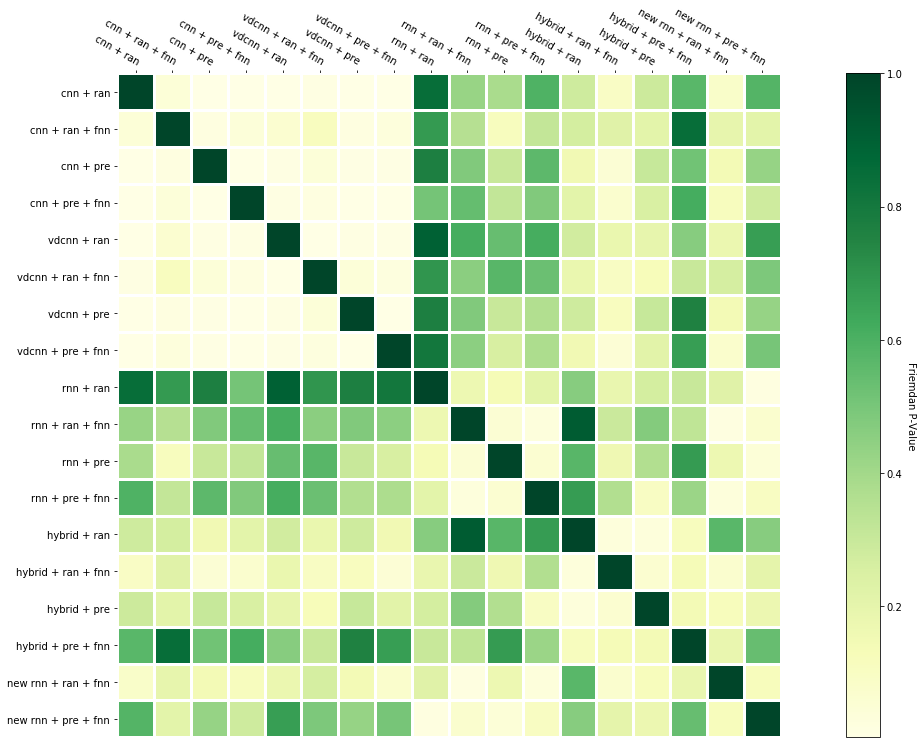

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.043589,0.006778,0.005321,0.003154,0.013403,0.006778,0.002980,0.847093,0.424222,0.382703,0.591807,0.279940,0.096382,0.290322,0.568108,0.081534,0.581146
cnn + ran + fnn,0.043589,1.000000,0.016319,0.035176,0.064290,0.108793,0.016319,0.027882,0.678247,0.349688,0.114954,0.311596,0.264271,0.221082,0.209453,0.844646,0.190822,0.211182
cnn + pre,0.006778,0.016319,1.000000,0.004525,0.014177,0.038639,0.008525,0.007992,0.767312,0.478702,0.299091,0.561590,0.152713,0.050982,0.306249,0.515008,0.144166,0.428720
cnn + pre + fnn,0.005321,0.035176,0.004525,1.000000,0.013720,0.018323,0.004525,0.005178,0.509240,0.541704,0.315400,0.478702,0.209440,0.068991,0.250155,0.618014,0.115453,0.280728
vdcnn + ran,0.003154,0.064290,0.014177,0.013720,1.000000,0.006206,0.014177,0.007236,0.894859,0.612387,0.540341,0.611341,0.273959,0.178283,0.190872,0.465066,0.176839,0.668654
vdcnn + ran + fnn,0.013403,0.108793,0.038639,0.018323,0.006206,1.000000,0.038639,0.024158,0.692513,0.457179,0.573747,0.528904,0.180612,0.097075,0.126252,0.301619,0.261778,0.488026
vdcnn + pre,0.006778,0.016319,0.008525,0.004525,0.014177,0.038639,1.000000,0.002929,0.767312,0.478702,0.299091,0.362065,0.282798,0.109964,0.306249,0.761413,0.144166,0.428720
vdcnn + pre + fnn,0.002980,0.027882,0.007992,0.005178,0.007236,0.024158,0.002929,1.000000,0.804491,0.451553,0.255950,0.374317,0.152713,0.048279,0.213723,0.666919,0.076546,0.502308
rnn + ran,0.847093,0.678247,0.767312,0.509240,0.894859,0.692513,0.767312,0.804491,1.000000,0.170119,0.138289,0.211182,0.465066,0.184637,0.266727,0.299204,0.223377,0.015233
rnn + ran + fnn,0.424222,0.349688,0.478702,0.541704,0.612387,0.457179,0.478702,0.451553,0.170119,1.000000,0.055193,0.030081,0.914799,0.292103,0.472994,0.326040,0.017599,0.067014


In [0]:
# Dietsupp_2mos
x = np.array([v for k, v in dietsupp_2mos.items()])
similarities_list.append(friedman_test(x))
plot_significance_matrix(friedman_test(x))
friedman_test(x)

In [0]:
# Advanced_cad
x = np.array([v for k, v in advanced_cad.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.143066,0.005649,0.043289,0.008774,0.465066,0.005649,0.465066,0.465066,0.465066,0.549154,0.465066,0.689782,0.098626,0.465066,0.385399,0.465066,0.465066
cnn + ran + fnn,0.143066,1.000000,0.298361,0.585915,0.283674,0.465066,0.298361,0.465066,0.465066,0.465066,0.585915,0.465066,0.567762,0.298361,0.465066,0.353113,0.465066,0.465066
cnn + pre,0.005649,0.298361,1.000000,0.014330,0.029279,0.465066,1.000000,0.465066,0.465066,0.465066,0.537470,0.465066,0.636393,0.575559,0.465066,0.395967,0.465066,0.465066
cnn + pre + fnn,0.043289,0.585915,0.014330,1.000000,0.113370,0.465066,0.014330,0.465066,0.465066,0.465066,0.517913,0.465066,0.565399,0.537470,0.465066,0.414004,0.465066,0.465066
vdcnn + ran,0.008774,0.283674,0.029279,0.113370,1.000000,0.465066,0.029279,0.465066,0.465066,0.465066,0.565399,0.465066,0.767312,0.191428,0.465066,0.370955,0.465066,0.465066
vdcnn + ran + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,1.000000,0.465066,1.000000,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000
vdcnn + pre,0.005649,0.298361,1.000000,0.014330,0.029279,0.465066,1.000000,0.465066,0.465066,0.465066,0.537470,0.465066,0.636393,0.575559,0.465066,0.395967,0.465066,0.465066
vdcnn + pre + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,1.000000,0.465066,1.000000,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000
rnn + ran,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,1.000000,0.465066,1.000000,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000
rnn + ran + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,1.000000,0.465066,1.000000,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000


In [0]:
# keto_1yr
x = np.array([v for k, v in keto_1yr.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# major_diabetes
x = np.array([v for k, v in major_diabetes.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.038063,0.429677,0.442450,0.009377,0.465066,0.008296,0.465066,0.465066,0.730560,0.702608,0.465066,0.491165,0.472994,0.114810,0.903389,0.636866,0.465066
cnn + ran + fnn,0.038063,1.000000,0.357221,0.135799,0.125197,0.465066,0.156397,0.465066,0.465066,0.710989,0.953753,0.465066,0.687563,0.183257,0.086811,0.630475,0.465066,0.465066
cnn + pre,0.429677,0.357221,1.000000,0.068669,0.449459,0.465066,0.266429,0.465066,0.465066,0.143066,0.618014,0.465066,0.063587,0.181853,0.396487,0.224346,0.064290,0.465066
cnn + pre + fnn,0.442450,0.135799,0.068669,1.000000,0.321418,0.465066,0.211182,0.465066,0.465066,0.216494,0.937696,0.465066,0.248497,0.180016,0.665849,0.759969,0.369779,0.465066
vdcnn + ran,0.009377,0.125197,0.449459,0.321418,1.000000,0.465066,0.017031,0.465066,0.465066,0.803257,0.628712,0.465066,0.317233,0.630954,0.224919,0.748398,0.540341,0.465066
vdcnn + ran + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,0.465066,0.465066,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000
vdcnn + pre,0.008296,0.156397,0.266429,0.211182,0.017031,0.465066,1.000000,0.465066,0.465066,0.396487,0.618014,0.465066,0.566679,0.574151,0.396487,0.863645,0.316150,0.465066
vdcnn + pre + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,0.465066,0.465066,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000
rnn + ran,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,0.465066,1.000000,1.000000,0.465066,0.465066,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000
rnn + ran + fnn,0.730560,0.710989,0.143066,0.216494,0.803257,0.465066,0.396487,0.465066,0.465066,1.000000,0.211182,0.465066,0.170989,0.276405,0.637340,0.310204,0.198299,0.465066


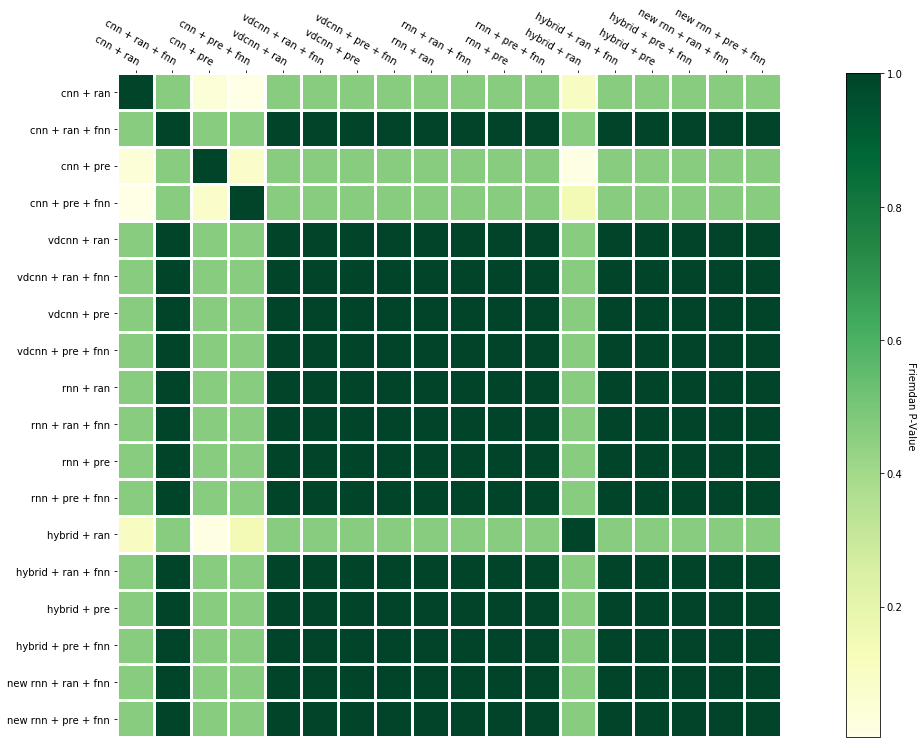

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.465066,0.043289,0.003737,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.098626,0.465066,0.465066,0.465066,0.465066,0.465066
cnn + ran + fnn,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000
cnn + pre,0.043289,0.465066,1.000000,0.078555,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.014330,0.465066,0.465066,0.465066,0.465066,0.465066
cnn + pre + fnn,0.003737,0.465066,0.078555,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.465066,0.146865,0.465066,0.465066,0.465066,0.465066,0.465066
vdcnn + ran,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000
vdcnn + ran + fnn,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000
vdcnn + pre,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000
vdcnn + pre + fnn,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000
rnn + ran,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000
rnn + ran + fnn,0.465066,1.000000,0.465066,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.465066,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# hba1c
x = np.array([v for k, v in hba1c.items()])
similarities_list.append(friedman_test(x))
plot_significance_matrix(friedman_test(x))
friedman_test(x)

In [0]:
# makes_decisions
x = np.array([v for k, v in makes_decisions.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# alcohol_abuse
x = np.array([v for k, v in alcohol_abuse.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# english
x = np.array([v for k, v in english.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# drug_abuse
x = np.array([v for k, v in drug_abuse.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# creatinine
x = np.array([v for k, v in creatinine.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.245414,0.411757,0.369829,0.231298,0.465066,0.465066,0.465066,0.566679,0.651007,0.465066,0.465066,0.245414,0.315791,0.758537,0.710989,0.651007,0.465066
cnn + ran + fnn,0.245414,1.000000,0.076156,0.618014,0.231298,0.465066,0.465066,0.465066,0.155997,0.651007,0.465066,0.465066,0.245414,0.086811,0.394082,0.315791,0.651007,0.465066
cnn + pre,0.411757,0.076156,1.000000,0.124301,0.326904,0.465066,0.465066,0.465066,0.487322,0.691729,0.465066,0.465066,0.411757,0.170989,0.248497,0.431908,0.691729,0.465066
cnn + pre + fnn,0.369829,0.618014,0.124301,1.000000,0.422147,0.465066,0.465066,0.465066,0.541704,0.750509,0.465066,0.465066,0.369829,0.557058,0.392887,0.276405,0.750509,0.465066
vdcnn + ran,0.231298,0.231298,0.326904,0.422147,1.000000,0.465066,0.465066,0.465066,0.509240,0.575559,0.465066,0.465066,0.651007,0.600822,0.620142,0.600822,0.575559,0.465066
vdcnn + ran + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,1.000000,1.000000,0.465066,0.465066,1.000000,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000
vdcnn + pre,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,1.000000,1.000000,0.465066,0.465066,1.000000,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000
vdcnn + pre + fnn,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000,1.000000,1.000000,0.465066,0.465066,1.000000,1.000000,0.465066,0.465066,0.465066,0.465066,0.465066,1.000000
rnn + ran,0.566679,0.155997,0.487322,0.541704,0.509240,0.465066,0.465066,0.465066,1.000000,0.223377,0.465066,0.465066,0.155997,0.159721,0.540857,0.378335,0.223377,0.465066
rnn + ran + fnn,0.651007,0.651007,0.691729,0.750509,0.575559,0.465066,0.465066,0.465066,0.223377,1.000000,0.465066,0.465066,0.231298,0.600822,0.620142,0.600822,1.000000,0.465066


In [0]:
# mi_6mos
x = np.array([v for k, v in mi_6mos.items()])
similarities_list.append(friedman_test(x))
friedman_test(x)

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
vdcnn + pre + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rnn + ran + fnn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
similarities_list
df_base = similarities_list[0] - similarities_list[0]

for df in similarities_list:
  df_base = df_base + df
  
df_base = df_base/len(similarities_list)
df_base

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.611677,0.608750,0.607899,0.597229,0.718364,0.611801,0.717562,0.790311,0.792942,0.771513,0.762857,0.713076,0.685687,0.743549,0.766391,0.751124,0.762037
cnn + ran + fnn,0.611677,1.000000,0.632098,0.686436,0.676030,0.766851,0.689973,0.760627,0.786880,0.827897,0.814212,0.782451,0.745780,0.711890,0.749333,0.774935,0.787464,0.774727
cnn + pre,0.608750,0.632098,1.000000,0.562973,0.643755,0.720305,0.710661,0.717948,0.778069,0.756119,0.757675,0.760532,0.672604,0.685347,0.728252,0.689418,0.715030,0.750312
cnn + pre + fnn,0.607899,0.686436,0.562973,1.000000,0.646201,0.718743,0.629415,0.717731,0.762401,0.770610,0.782016,0.754156,0.692700,0.713359,0.755239,0.727969,0.740842,0.738928
vdcnn + ran,0.597229,0.676030,0.643755,0.646201,1.000000,0.758959,0.658064,0.759039,0.830715,0.845672,0.820353,0.805508,0.764588,0.774350,0.772190,0.778106,0.786375,0.809917
vdcnn + ran + fnn,0.718364,0.766851,0.720305,0.718743,0.758959,1.000000,0.802603,0.924935,0.935198,0.834798,0.884914,0.963762,0.772375,0.807098,0.809342,0.781683,0.860916,0.960617
vdcnn + pre,0.611801,0.689973,0.710661,0.629415,0.658064,0.802603,1.000000,0.799856,0.817506,0.797748,0.839972,0.827482,0.760082,0.783831,0.784482,0.801248,0.758117,0.832609
vdcnn + pre + fnn,0.717562,0.760627,0.717948,0.717731,0.759039,0.924935,0.799856,1.000000,0.943812,0.834365,0.860468,0.951871,0.770229,0.803344,0.816071,0.809783,0.846668,0.961716
rnn + ran,0.790311,0.786880,0.778069,0.762401,0.830715,0.935198,0.817506,0.943812,1.000000,0.794125,0.810268,0.898173,0.770482,0.790345,0.825978,0.774826,0.839371,0.883100
rnn + ran + fnn,0.792942,0.827897,0.756119,0.770610,0.845672,0.834798,0.797748,0.834365,0.794125,1.000000,0.743198,0.801945,0.747099,0.776882,0.865261,0.740943,0.821613,0.804786


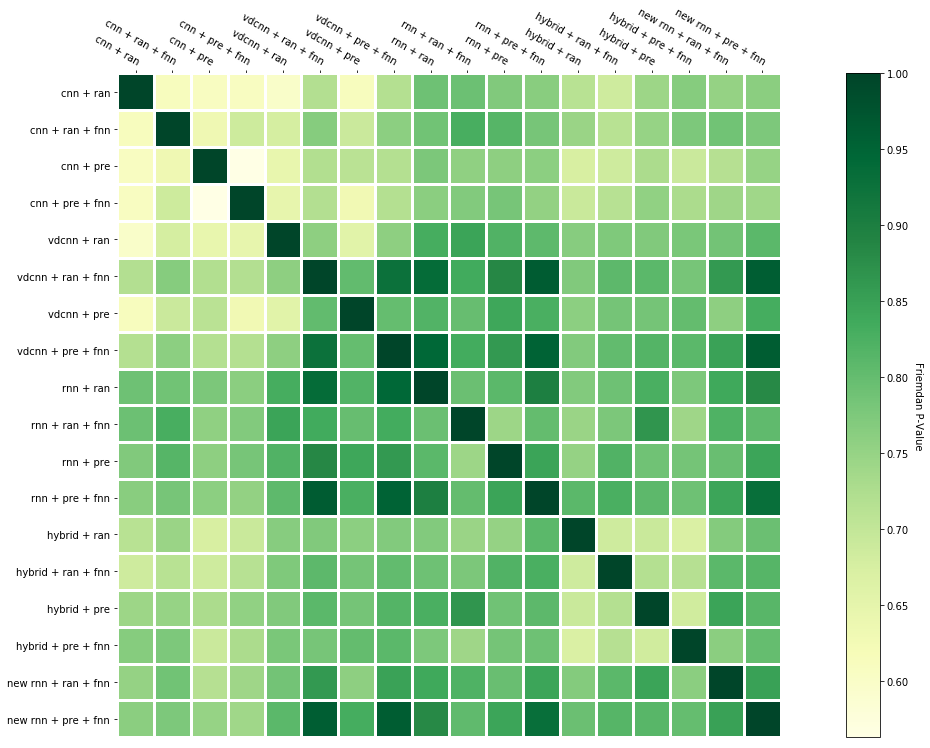

In [0]:
 plot_significance_matrix(df_base)

In [0]:
test_y

array([[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,

In [0]:
similarities_list[0] - similarities_list[0]

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cnn + ran + fnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cnn + pre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cnn + pre + fnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vdcnn + ran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vdcnn + ran + fnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vdcnn + pre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vdcnn + pre + fnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rnn + ran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rnn + ran + fnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
occurrences = sum(test_y)
total = sum(occurrences)

similarities_list
df_base_micro = similarities_list[0] - similarities_list[0]

for i, df in enumerate(similarities_list):
  df_base_micro = df_base_micro + df*occurrences[i]/total
  
df_base_micro = df_base_micro
df_base_micro

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,hybrid + ran,hybrid + ran + fnn,hybrid + pre,hybrid + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn
cnn + ran,1.000000,0.581599,0.586304,0.587835,0.562625,0.695954,0.572646,0.694918,0.784485,0.780888,0.764617,0.753435,0.712328,0.660227,0.712399,0.724051,0.730192,0.752375
cnn + ran + fnn,0.581599,1.000000,0.615727,0.659899,0.643327,0.738659,0.652741,0.730618,0.777974,0.805690,0.799846,0.758814,0.740923,0.684101,0.715361,0.732336,0.757205,0.748835
cnn + pre,0.586304,0.615727,1.000000,0.537985,0.617408,0.698462,0.699404,0.695416,0.772120,0.731122,0.746740,0.750432,0.655950,0.666084,0.714391,0.636741,0.681791,0.737228
cnn + pre + fnn,0.587835,0.659899,0.537985,1.000000,0.617018,0.696443,0.594790,0.695136,0.749514,0.747500,0.778187,0.742195,0.678796,0.685488,0.743191,0.693307,0.712582,0.722520
vdcnn + ran,0.562625,0.643327,0.617408,0.617018,1.000000,0.728464,0.611649,0.728567,0.819247,0.833438,0.807780,0.788602,0.747587,0.742446,0.736566,0.724040,0.759079,0.794298
vdcnn + ran + fnn,0.695954,0.738659,0.698462,0.696443,0.728464,1.000000,0.761591,0.903022,0.939539,0.826443,0.851317,0.953183,0.749119,0.774043,0.793555,0.717951,0.843572,0.949121
vdcnn + pre,0.572646,0.652741,0.699404,0.594790,0.611649,0.761591,1.000000,0.758042,0.804102,0.775460,0.809869,0.793732,0.749850,0.760597,0.758322,0.759840,0.727375,0.800356
vdcnn + pre + fnn,0.694918,0.730618,0.695416,0.695136,0.728567,0.903022,0.758042,1.000000,0.950667,0.825883,0.819735,0.937820,0.746346,0.769194,0.802248,0.754254,0.825164,0.950540
rnn + ran,0.784485,0.777974,0.772120,0.749514,0.819247,0.939539,0.804102,0.950667,1.000000,0.784404,0.778139,0.891705,0.760111,0.765676,0.811752,0.712863,0.826245,0.872232
rnn + ran + fnn,0.780888,0.805690,0.731122,0.747500,0.833438,0.826443,0.775460,0.825883,0.784404,1.000000,0.708102,0.783998,0.743241,0.745716,0.857414,0.676029,0.786150,0.787668


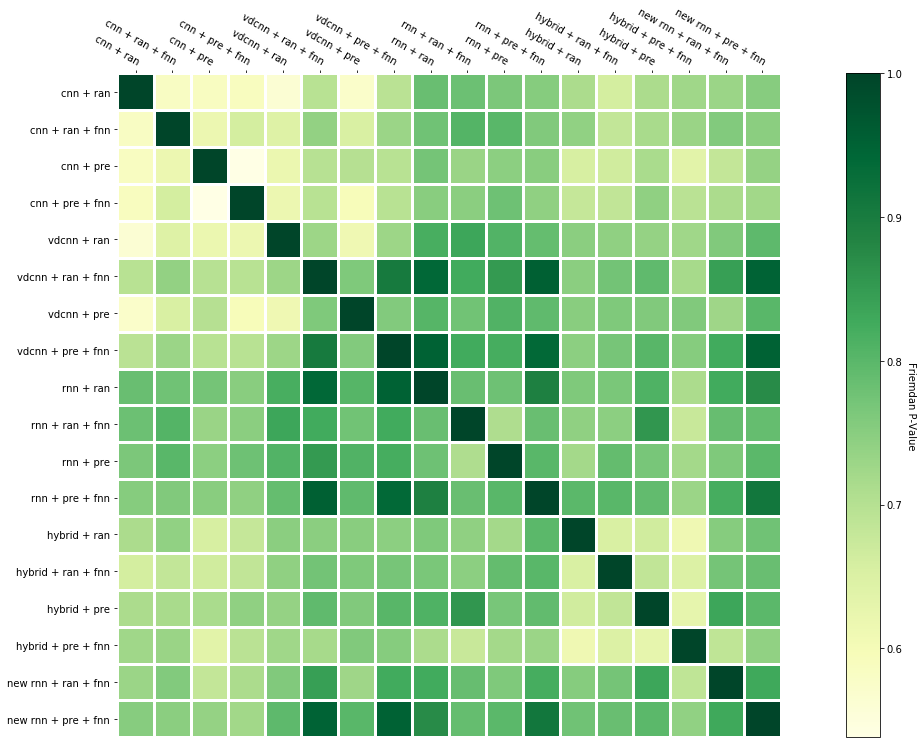

In [0]:
 plot_significance_matrix(df_base_micro)

Nemenyi-Friedman
===============
Calculate pairwise comparisons using Nemenyi post-hoc test for unreplicated blocked data.

This test is usually conducted post-hoc after significant results of the Friedman’s test. 

The statistics refer to upper quantiles of the studentized range distribution (Tukey).


In [0]:
# Asp for MI
x = np.array([v for k, v in asp_for_mi.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
1,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
2,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
3,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
4,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
5,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
6,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
7,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
8,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000
9,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000


In [0]:
# Abdominal
x = np.array([v for k, v in abdominal.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# Dietsupp_2mos
x = np.array([v for k, v in dietsupp_2mos.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.737646,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.051095,0.900000,0.900000,0.900000,0.900000,0.900000,0.595211,0.900000,0.900000,0.177805
1,0.737646,-1.000000,0.900000,0.880085,0.449703,0.099080,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.051095,0.880085,0.900000
2,0.900000,0.900000,-1.000000,0.900000,0.900000,0.880085,0.900000,0.900000,0.449703,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.737646,0.900000,0.737646
3,0.900000,0.880085,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.099080,0.900000,0.900000,0.900000,0.900000,0.900000,0.737646,0.900000,0.900000,0.294848
4,0.900000,0.449703,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.010970,0.900000,0.880085,0.900000,0.900000,0.900000,0.294848,0.900000,0.900000,0.051095
5,0.900000,0.099080,0.880085,0.900000,0.900000,-1.000000,0.880085,0.900000,0.001000,0.737646,0.449703,0.900000,0.900000,0.880085,0.051095,0.900000,0.900000,0.004614
6,0.900000,0.900000,0.900000,0.900000,0.900000,0.880085,-1.000000,0.900000,0.449703,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.737646,0.900000,0.737646
7,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.177805,0.900000,0.900000,0.900000,0.900000,0.900000,0.880085,0.900000,0.900000,0.449703
8,0.051095,0.900000,0.449703,0.099080,0.010970,0.001000,0.449703,0.177805,-1.000000,0.595211,0.880085,0.177805,0.294848,0.449703,0.900000,0.001000,0.099080,0.900000
9,0.900000,0.900000,0.900000,0.900000,0.900000,0.737646,0.900000,0.900000,0.595211,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.595211,0.900000,0.880085


In [0]:
# Advanced_cad
x = np.array([v for k, v in advanced_cad.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
1,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
2,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
3,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
4,0.900,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
5,0.900,0.900,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
6,0.900,0.900,0.900,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
7,0.900,0.900,0.900,0.900,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
8,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900
9,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,-1.000,0.900,0.900,0.900,0.900,0.900,0.001,0.900,0.900


In [0]:
# keto_1yr
x = np.array([v for k, v in keto_1yr.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# major_diabetes
x = np.array([v for k, v in major_diabetes.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.177805,0.900000,0.900000,0.900000,0.900000,0.001827,0.294848,0.900000
1,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.099080,0.900000,0.900000,0.900000,0.900000,0.001000,0.177805,0.900000
2,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.294848,0.900000,0.900000,0.900000,0.900000,0.004614,0.449703,0.900000
3,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.024479,0.900000,0.900000,0.880085,0.900000,0.001000,0.051095,0.900000
4,0.900000,0.900000,0.900000,0.900000,-1.000000,0.595211,0.900000,0.595211,0.595211,0.900000,0.737646,0.595211,0.900000,0.900000,0.900000,0.051095,0.880085,0.595211
5,0.900000,0.900000,0.900000,0.900000,0.595211,-1.000000,0.900000,0.900000,0.900000,0.900000,0.001000,0.900000,0.880085,0.294848,0.900000,0.001000,0.001827,0.900000
6,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.900000,0.900000,0.900000,0.294848,0.900000,0.900000,0.900000,0.900000,0.004614,0.449703,0.900000
7,0.900000,0.900000,0.900000,0.900000,0.595211,0.900000,0.900000,-1.000000,0.900000,0.900000,0.001000,0.900000,0.880085,0.294848,0.900000,0.001000,0.001827,0.900000
8,0.900000,0.900000,0.900000,0.900000,0.595211,0.900000,0.900000,0.900000,-1.000000,0.900000,0.001000,0.900000,0.880085,0.294848,0.900000,0.001000,0.001827,0.900000
9,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,-1.000000,0.010970,0.900000,0.900000,0.737646,0.900000,0.001000,0.024479,0.900000


In [0]:
# hba1c
x = np.array([v for k, v in hba1c.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# makes_decisions
x = np.array([v for k, v in makes_decisions.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# alcohol_abuse
x = np.array([v for k, v in alcohol_abuse.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# english
x = np.array([v for k, v in english.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# drug_abuse
x = np.array([v for k, v in drug_abuse.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [0]:
# creatinine
x = np.array([v for k, v in creatinine.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.595211,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
1,0.900000,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.595211,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
2,0.900000,0.900000,-1.000000,0.900000,0.900000,0.880085,0.880085,0.880085,0.900000,0.900000,0.880085,0.880085,0.900000,0.900000,0.900000,0.900000,0.900000,0.880085
3,0.900000,0.900000,0.900000,-1.000000,0.595211,0.294848,0.294848,0.294848,0.900000,0.595211,0.294848,0.294848,0.900000,0.737646,0.880085,0.737646,0.595211,0.294848
4,0.900000,0.900000,0.900000,0.595211,-1.000000,0.900000,0.900000,0.900000,0.099080,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
5,0.900000,0.900000,0.880085,0.294848,0.900000,-1.000000,0.900000,0.900000,0.024479,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
6,0.900000,0.900000,0.880085,0.294848,0.900000,0.900000,-1.000000,0.900000,0.024479,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
7,0.900000,0.900000,0.880085,0.294848,0.900000,0.900000,0.900000,-1.000000,0.024479,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
8,0.595211,0.595211,0.900000,0.900000,0.099080,0.024479,0.024479,0.024479,-1.000000,0.099080,0.024479,0.024479,0.595211,0.177805,0.294848,0.177805,0.099080,0.024479
9,0.900000,0.900000,0.900000,0.595211,0.900000,0.900000,0.900000,0.900000,0.099080,-1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000


In [0]:
# mi_6mos
x = np.array([v for k, v in mi_6mos.items()]).transpose()
sp.posthoc_nemenyi_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
5,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
6,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,-1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


Conover-Friedman
===============
Calculate pairwise comparisons using Conover post-hoc test for unreplicated blocked data. 

This test is usually conducted post-hoc after significant results of the Friedman test.

The statistics refer to the Student t distribution.



In [0]:
# Asp for MI
x = np.array([v for k, v in asp_for_mi.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
1,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
2,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
3,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
4,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
5,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
6,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
7,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
8,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00
9,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.453797e-27,1.000000e+00,1.000000e+00


In [0]:
# Abdominal
x = np.array([v for k, v in abdominal.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.283896,0.283896,0.591932,0.032396,0.001374,0.591932,0.001374,0.001374,0.007565,0.001374,0.001374,0.001374,0.001374,0.007565,0.001374,0.001374,0.001374
1,0.283896,-1.000000,1.000000,0.591932,0.001374,0.000021,0.108221,0.000021,0.000021,0.000194,0.000021,0.000021,0.000021,0.000021,0.000194,0.000021,0.000021,0.000021
2,0.283896,1.000000,-1.000000,0.591932,0.001374,0.000021,0.108221,0.000021,0.000021,0.000194,0.000021,0.000021,0.000021,0.000021,0.000194,0.000021,0.000021,0.000021
3,0.591932,0.591932,0.591932,-1.000000,0.007565,0.000194,0.283896,0.000194,0.000194,0.001374,0.000194,0.000194,0.000194,0.000194,0.001374,0.000194,0.000194,0.000194
4,0.032396,0.001374,0.001374,0.007565,-1.000000,0.283896,0.108221,0.283896,0.283896,0.591932,0.283896,0.283896,0.283896,0.283896,0.591932,0.283896,0.283896,0.283896
5,0.001374,0.000021,0.000021,0.000194,0.283896,-1.000000,0.007565,1.000000,1.000000,0.591932,1.000000,1.000000,1.000000,1.000000,0.591932,1.000000,1.000000,1.000000
6,0.591932,0.108221,0.108221,0.283896,0.108221,0.007565,-1.000000,0.007565,0.007565,0.032396,0.007565,0.007565,0.007565,0.007565,0.032396,0.007565,0.007565,0.007565
7,0.001374,0.000021,0.000021,0.000194,0.283896,1.000000,0.007565,-1.000000,1.000000,0.591932,1.000000,1.000000,1.000000,1.000000,0.591932,1.000000,1.000000,1.000000
8,0.001374,0.000021,0.000021,0.000194,0.283896,1.000000,0.007565,1.000000,-1.000000,0.591932,1.000000,1.000000,1.000000,1.000000,0.591932,1.000000,1.000000,1.000000
9,0.007565,0.000194,0.000194,0.001374,0.591932,0.591932,0.032396,0.591932,0.591932,-1.000000,0.591932,0.591932,0.591932,0.591932,1.000000,0.591932,0.591932,0.591932


In [0]:
# Dietsupp_2mos
x = np.array([v for k, v in dietsupp_2mos.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.004318,0.251983,0.774445,5.666049e-01,1.523167e-01,0.251983,0.566605,5.694994e-06,0.152317,0.045289,0.566605,0.390115,0.251983,0.001709,8.599906e-02,0.774445,6.895268e-05
1,0.004318,-1.000000,0.085999,0.010154,6.295594e-04,2.052129e-05,0.085999,0.022223,8.599906e-02,0.152317,0.390115,0.022223,0.045289,0.085999,0.774445,5.694994e-06,0.010154,2.519834e-01
2,0.251983,0.085999,-1.000000,0.390115,8.599906e-02,1.015373e-02,1.000000,0.566605,6.295594e-04,0.774445,0.390115,0.566605,0.774445,1.000000,0.045289,4.318160e-03,0.390115,4.318160e-03
3,0.774445,0.010154,0.390115,-1.000000,3.901148e-01,8.599906e-02,0.390115,0.774445,2.052129e-05,0.251983,0.085999,0.774445,0.566605,0.390115,0.004318,4.528893e-02,1.000000,2.158944e-04
4,0.566605,0.000630,0.085999,0.390115,-1.000000e+00,3.901148e-01,0.085999,0.251983,3.567570e-07,0.045289,0.010154,0.251983,0.152317,0.085999,0.000216,2.519834e-01,0.390115,5.694994e-06
5,0.152317,0.000021,0.010154,0.085999,3.901148e-01,-1.000000e+00,0.010154,0.045289,3.386002e-09,0.004318,0.000630,0.045289,0.022223,0.010154,0.000006,7.744453e-01,0.085999,8.067911e-08
6,0.251983,0.085999,1.000000,0.390115,8.599906e-02,1.015373e-02,-1.000000,0.566605,6.295594e-04,0.774445,0.390115,0.566605,0.774445,1.000000,0.045289,4.318160e-03,0.390115,4.318160e-03
7,0.566605,0.022223,0.566605,0.774445,2.519834e-01,4.528893e-02,0.566605,-1.000000,6.895268e-05,0.390115,0.152317,1.000000,0.774445,0.566605,0.010154,2.222289e-02,0.774445,6.295594e-04
8,0.000006,0.085999,0.000630,0.000021,3.567570e-07,3.386002e-09,0.000630,0.000069,-1.000000e+00,0.001709,0.010154,0.000069,0.000216,0.000630,0.152317,6.298142e-10,0.000021,5.666049e-01
9,0.152317,0.152317,0.774445,0.251983,4.528893e-02,4.318160e-03,0.774445,0.390115,1.709067e-03,-1.000000,0.566605,0.390115,0.566605,0.774445,0.085999,1.709067e-03,0.251983,1.015373e-02


In [0]:
# Advanced_cad
x = np.array([v for k, v in advanced_cad.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000e+00,3.775242e-02,6.771307e-01,4.051021e-01,4.051021e-01,2.119332e-01,6.771307e-01,2.119332e-01,2.119332e-01,2.119332e-01,4.051021e-01,2.119332e-01,4.051021e-01,6.771307e-01,2.119332e-01,1.129834e-24,2.119332e-01,2.119332e-01
1,3.775242e-02,-1.000000e+00,1.275103e-02,3.702272e-03,2.119332e-01,9.236405e-04,1.275103e-02,9.236405e-04,9.236405e-04,9.236405e-04,3.702272e-03,9.236405e-04,2.119332e-01,1.275103e-02,9.236405e-04,3.419695e-17,9.236405e-04,9.236405e-04
2,6.771307e-01,1.275103e-02,-1.000000e+00,6.771307e-01,2.119332e-01,4.051021e-01,1.000000e+00,4.051021e-01,4.051021e-01,4.051021e-01,6.771307e-01,4.051021e-01,2.119332e-01,1.000000e+00,4.051021e-01,2.744959e-26,4.051021e-01,4.051021e-01
3,4.051021e-01,3.702272e-03,6.771307e-01,-1.000000e+00,9.624535e-02,6.771307e-01,6.771307e-01,6.771307e-01,6.771307e-01,6.771307e-01,1.000000e+00,6.771307e-01,9.624535e-02,6.771307e-01,6.771307e-01,6.154791e-28,6.771307e-01,6.771307e-01
4,4.051021e-01,2.119332e-01,2.119332e-01,9.624535e-02,-1.000000e+00,3.775242e-02,2.119332e-01,3.775242e-02,3.775242e-02,3.775242e-02,9.624535e-02,3.775242e-02,1.000000e+00,2.119332e-01,3.775242e-02,1.477838e-21,3.775242e-02,3.775242e-02
5,2.119332e-01,9.236405e-04,4.051021e-01,6.771307e-01,3.775242e-02,-1.000000e+00,4.051021e-01,1.000000e+00,1.000000e+00,1.000000e+00,6.771307e-01,1.000000e+00,3.775242e-02,4.051021e-01,1.000000e+00,1.279291e-29,1.000000e+00,1.000000e+00
6,6.771307e-01,1.275103e-02,1.000000e+00,6.771307e-01,2.119332e-01,4.051021e-01,-1.000000e+00,4.051021e-01,4.051021e-01,4.051021e-01,6.771307e-01,4.051021e-01,2.119332e-01,1.000000e+00,4.051021e-01,2.744959e-26,4.051021e-01,4.051021e-01
7,2.119332e-01,9.236405e-04,4.051021e-01,6.771307e-01,3.775242e-02,1.000000e+00,4.051021e-01,-1.000000e+00,1.000000e+00,1.000000e+00,6.771307e-01,1.000000e+00,3.775242e-02,4.051021e-01,1.000000e+00,1.279291e-29,1.000000e+00,1.000000e+00
8,2.119332e-01,9.236405e-04,4.051021e-01,6.771307e-01,3.775242e-02,1.000000e+00,4.051021e-01,1.000000e+00,-1.000000e+00,1.000000e+00,6.771307e-01,1.000000e+00,3.775242e-02,4.051021e-01,1.000000e+00,1.279291e-29,1.000000e+00,1.000000e+00
9,2.119332e-01,9.236405e-04,4.051021e-01,6.771307e-01,3.775242e-02,1.000000e+00,4.051021e-01,1.000000e+00,1.000000e+00,-1.000000e+00,6.771307e-01,1.000000e+00,3.775242e-02,4.051021e-01,1.000000e+00,1.279291e-29,1.000000e+00,1.000000e+00


In [0]:
# keto_1yr
x = np.array([v for k, v in keto_1yr.items()]).transpose()
sp.posthoc_conover_friedman(x)

/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in double_scalars
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in sqrt
  tval = dif / np.sqrt(A) / np.sqrt(B)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# major_diabetes
x = np.array([v for k, v in major_diabetes.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000e+00,7.680215e-01,7.680215e-01,3.763837e-01,0.238368,3.936121e-02,7.680215e-01,3.936121e-02,3.936121e-02,2.383683e-01,4.229226e-05,3.936121e-02,5.552916e-01,0.077219,2.383683e-01,6.665817e-09,1.409282e-04,3.936121e-02
1,7.680215e-01,-1.000000e+00,5.552916e-01,5.552916e-01,0.140681,7.721869e-02,5.552916e-01,7.721869e-02,7.721869e-02,3.763837e-01,1.178053e-05,7.721869e-02,3.763837e-01,0.039361,3.763837e-01,1.211497e-09,4.229226e-05,7.721869e-02
2,7.680215e-01,5.552916e-01,-1.000000e+00,2.383683e-01,0.376384,1.861334e-02,1.000000e+00,1.861334e-02,1.861334e-02,1.406810e-01,1.409282e-04,1.861334e-02,7.680215e-01,0.140681,1.406810e-01,3.425443e-08,4.356038e-04,1.861334e-02
3,3.763837e-01,5.552916e-01,2.383683e-01,-1.000000e+00,0.039361,2.383683e-01,2.383683e-01,2.383683e-01,2.383683e-01,7.680215e-01,7.333432e-07,2.383683e-01,1.406810e-01,0.008160,7.680215e-01,3.277606e-11,3.048247e-06,2.383683e-01
4,2.383683e-01,1.406810e-01,3.763837e-01,3.936121e-02,-1.000000,1.248312e-03,3.763837e-01,1.248312e-03,1.248312e-03,1.861334e-02,3.315482e-03,1.248312e-03,5.552916e-01,0.555292,1.861334e-02,3.048247e-06,8.160208e-03,1.248312e-03
5,3.936121e-02,7.721869e-02,1.861334e-02,2.383683e-01,0.001248,-1.000000e+00,1.861334e-02,1.000000e+00,1.000000e+00,3.763837e-01,1.211497e-09,1.000000e+00,8.160208e-03,0.000141,3.763837e-01,1.123398e-14,6.665817e-09,1.000000e+00
6,7.680215e-01,5.552916e-01,1.000000e+00,2.383683e-01,0.376384,1.861334e-02,-1.000000e+00,1.861334e-02,1.861334e-02,1.406810e-01,1.409282e-04,1.861334e-02,7.680215e-01,0.140681,1.406810e-01,3.425443e-08,4.356038e-04,1.861334e-02
7,3.936121e-02,7.721869e-02,1.861334e-02,2.383683e-01,0.001248,1.000000e+00,1.861334e-02,-1.000000e+00,1.000000e+00,3.763837e-01,1.211497e-09,1.000000e+00,8.160208e-03,0.000141,3.763837e-01,1.123398e-14,6.665817e-09,1.000000e+00
8,3.936121e-02,7.721869e-02,1.861334e-02,2.383683e-01,0.001248,1.000000e+00,1.861334e-02,1.000000e+00,-1.000000e+00,3.763837e-01,1.211497e-09,1.000000e+00,8.160208e-03,0.000141,3.763837e-01,1.123398e-14,6.665817e-09,1.000000e+00
9,2.383683e-01,3.763837e-01,1.406810e-01,7.680215e-01,0.018613,3.763837e-01,1.406810e-01,3.763837e-01,3.763837e-01,-1.000000e+00,1.641993e-07,3.763837e-01,7.721869e-02,0.003315,1.000000e+00,4.892502e-12,7.333432e-07,3.763837e-01


In [0]:
# hba1c
x = np.array([v for k, v in hba1c.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.001865,0.037561,0.297635,0.001865,0.001865,0.001865,0.001865,0.001865,0.001865,0.001865,0.001865,0.297635,0.001865,0.001865,0.001865,0.001865,0.001865
1,0.001865,-1.000000,0.297635,0.000036,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.037561,0.297635,-1.000000,0.001865,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635,0.297635
3,0.297635,0.000036,0.001865,-1.000000,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.037561,0.000036,0.000036,0.000036,0.000036,0.000036
4,0.001865,1.000000,0.297635,0.000036,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.001865,1.000000,0.297635,0.000036,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.001865,1.000000,0.297635,0.000036,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.001865,1.000000,0.297635,0.000036,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.001865,1.000000,0.297635,0.000036,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.001865,1.000000,0.297635,0.000036,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,0.037561,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# makes_decisions
x = np.array([v for k, v in makes_decisions.items()]).transpose()
sp.posthoc_conover_friedman(x)

/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in double_scalars
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in sqrt
  tval = dif / np.sqrt(A) / np.sqrt(B)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# alcohol_abuse
x = np.array([v for k, v in alcohol_abuse.items()]).transpose()
sp.posthoc_conover_friedman(x)

/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in double_scalars
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in sqrt
  tval = dif / np.sqrt(A) / np.sqrt(B)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# english
x = np.array([v for k, v in english.items()]).transpose()
sp.posthoc_conover_friedman(x)

/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in double_scalars
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in sqrt
  tval = dif / np.sqrt(A) / np.sqrt(B)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# drug_abuse
x = np.array([v for k, v in drug_abuse.items()]).transpose()
sp.posthoc_conover_friedman(x)

/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in double_scalars
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in sqrt
  tval = dif / np.sqrt(A) / np.sqrt(B)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# creatinine
x = np.array([v for k, v in creatinine.items()]).transpose()
sp.posthoc_conover_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,1.000000,0.255953,0.008217,1.300495e-01,2.335522e-02,2.335522e-02,2.335522e-02,3.595811e-05,1.300495e-01,2.335522e-02,2.335522e-02,1.000000,2.559534e-01,0.448682,2.559534e-01,1.300495e-01,2.335522e-02
1,1.000000,-1.000000,0.255953,0.008217,1.300495e-01,2.335522e-02,2.335522e-02,2.335522e-02,3.595811e-05,1.300495e-01,2.335522e-02,2.335522e-02,1.000000,2.559534e-01,0.448682,2.559534e-01,1.300495e-01,2.335522e-02
2,0.255953,0.255953,-1.000000,0.130050,8.216947e-03,6.979573e-04,6.979573e-04,6.979573e-04,2.550016e-03,8.216947e-03,6.979573e-04,6.979573e-04,0.255953,2.335522e-02,0.058605,2.335522e-02,8.216947e-03,6.979573e-04
3,0.008217,0.008217,0.130050,-1.000000,3.595811e-05,1.134030e-06,1.134030e-06,1.134030e-06,1.300495e-01,3.595811e-05,1.134030e-06,1.134030e-06,0.008217,1.685675e-04,0.000698,1.685675e-04,3.595811e-05,1.134030e-06
4,0.130050,0.130050,0.008217,0.000036,-1.000000e+00,4.486822e-01,4.486822e-01,4.486822e-01,2.222277e-08,1.000000e+00,4.486822e-01,4.486822e-01,0.130050,7.047698e-01,0.448682,7.047698e-01,1.000000e+00,4.486822e-01
5,0.023355,0.023355,0.000698,0.000001,4.486822e-01,-1.000000e+00,1.000000e+00,1.000000e+00,2.758120e-10,4.486822e-01,1.000000e+00,1.000000e+00,0.023355,2.559534e-01,0.130050,2.559534e-01,4.486822e-01,1.000000e+00
6,0.023355,0.023355,0.000698,0.000001,4.486822e-01,1.000000e+00,-1.000000e+00,1.000000e+00,2.758120e-10,4.486822e-01,1.000000e+00,1.000000e+00,0.023355,2.559534e-01,0.130050,2.559534e-01,4.486822e-01,1.000000e+00
7,0.023355,0.023355,0.000698,0.000001,4.486822e-01,1.000000e+00,1.000000e+00,-1.000000e+00,2.758120e-10,4.486822e-01,1.000000e+00,1.000000e+00,0.023355,2.559534e-01,0.130050,2.559534e-01,4.486822e-01,1.000000e+00
8,0.000036,0.000036,0.002550,0.130050,2.222277e-08,2.758120e-10,2.758120e-10,2.758120e-10,-1.000000e+00,2.222277e-08,2.758120e-10,2.758120e-10,0.000036,1.682910e-07,0.000001,1.682910e-07,2.222277e-08,2.758120e-10
9,0.130050,0.130050,0.008217,0.000036,1.000000e+00,4.486822e-01,4.486822e-01,4.486822e-01,2.222277e-08,-1.000000e+00,4.486822e-01,4.486822e-01,0.130050,7.047698e-01,0.448682,7.047698e-01,1.000000e+00,4.486822e-01


In [0]:
# mi_6mos
x = np.array([v for k, v in mi_6mos.items()]).transpose()
sp.posthoc_conover_friedman(x)

/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in double_scalars
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.6/dist-packages/scikit_posthocs/_posthocs.py:687: RuntimeWarning: invalid value encountered in sqrt
  tval = dif / np.sqrt(A) / np.sqrt(B)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Siegel-Friedman
=============
Siegel and Castellan’s All-Pairs Comparisons Test for Unreplicated Blocked Data.

The p-values are computed from the standard normal distribution.

In [0]:
# Asp for MI
x = np.array([v for k, v in asp_for_mi.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
1,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
2,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
3,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002311,1.000000,1.000000


In [0]:
# Abdominal
x = np.array([v for k, v in abdominal.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.663355,0.663355,0.827707,0.383988,0.191601,0.827707,0.191601,0.191601,0.276500,0.191601,0.191601,0.191601,0.191601,0.276500,0.191601,0.191601,0.191601
1,0.663355,-1.000000,1.000000,0.827707,0.191601,0.081659,0.513802,0.081659,0.081659,0.127634,0.081659,0.081659,0.081659,0.081659,0.127634,0.081659,0.081659,0.081659
2,0.663355,1.000000,-1.000000,0.827707,0.191601,0.081659,0.513802,0.081659,0.081659,0.127634,0.081659,0.081659,0.081659,0.081659,0.127634,0.081659,0.081659,0.081659
3,0.827707,0.827707,0.827707,-1.000000,0.276500,0.127634,0.663355,0.127634,0.127634,0.191601,0.127634,0.127634,0.127634,0.127634,0.191601,0.127634,0.127634,0.127634
4,0.383988,0.191601,0.191601,0.276500,-1.000000,0.663355,0.513802,0.663355,0.663355,0.827707,0.663355,0.663355,0.663355,0.663355,0.827707,0.663355,0.663355,0.663355
5,0.191601,0.081659,0.081659,0.127634,0.663355,-1.000000,0.276500,1.000000,1.000000,0.827707,1.000000,1.000000,1.000000,1.000000,0.827707,1.000000,1.000000,1.000000
6,0.827707,0.513802,0.513802,0.663355,0.513802,0.276500,-1.000000,0.276500,0.276500,0.383988,0.276500,0.276500,0.276500,0.276500,0.383988,0.276500,0.276500,0.276500
7,0.191601,0.081659,0.081659,0.127634,0.663355,1.000000,0.276500,-1.000000,1.000000,0.827707,1.000000,1.000000,1.000000,1.000000,0.827707,1.000000,1.000000,1.000000
8,0.191601,0.081659,0.081659,0.127634,0.663355,1.000000,0.276500,1.000000,-1.000000,0.827707,1.000000,1.000000,1.000000,1.000000,0.827707,1.000000,1.000000,1.000000
9,0.276500,0.127634,0.127634,0.191601,0.827707,0.827707,0.383988,0.827707,0.827707,-1.000000,0.827707,0.827707,0.827707,0.827707,1.000000,0.827707,0.827707,0.827707


In [0]:
# Dietsupp_2mos
x = np.array([v for k, v in dietsupp_2mos.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.029523,0.383988,0.827707,0.663355,0.276500,0.383988,0.663355,0.000497,0.276500,0.127634,0.663355,0.513802,0.383988,0.016662,0.191601,0.827707,0.002311
1,0.029523,-1.000000,0.191601,0.050138,0.009009,0.001096,0.191601,0.081659,0.191601,0.276500,0.513802,0.081659,0.127634,0.191601,0.827707,0.000497,0.050138,0.383988
2,0.383988,0.191601,-1.000000,0.513802,0.191601,0.050138,1.000000,0.663355,0.009009,0.827707,0.513802,0.663355,0.827707,1.000000,0.127634,0.029523,0.513802,0.029523
3,0.827707,0.050138,0.513802,-1.000000,0.513802,0.191601,0.513802,0.827707,0.001096,0.383988,0.191601,0.827707,0.663355,0.513802,0.029523,0.127634,1.000000,0.004664
4,0.663355,0.009009,0.191601,0.513802,-1.000000,0.513802,0.191601,0.383988,0.000089,0.127634,0.050138,0.383988,0.276500,0.191601,0.004664,0.383988,0.513802,0.000497
5,0.276500,0.001096,0.050138,0.191601,0.513802,-1.000000,0.050138,0.127634,0.000005,0.029523,0.009009,0.127634,0.081659,0.050138,0.000497,0.827707,0.191601,0.000035
6,0.383988,0.191601,1.000000,0.513802,0.191601,0.050138,-1.000000,0.663355,0.009009,0.827707,0.513802,0.663355,0.827707,1.000000,0.127634,0.029523,0.513802,0.029523
7,0.663355,0.081659,0.663355,0.827707,0.383988,0.127634,0.663355,-1.000000,0.002311,0.513802,0.276500,1.000000,0.827707,0.663355,0.050138,0.081659,0.827707,0.009009
8,0.000497,0.191601,0.009009,0.001096,0.000089,0.000005,0.009009,0.002311,-1.000000,0.016662,0.050138,0.002311,0.004664,0.009009,0.276500,0.000002,0.001096,0.663355
9,0.276500,0.276500,0.827707,0.383988,0.127634,0.029523,0.827707,0.513802,0.016662,-1.000000,0.663355,0.513802,0.663355,0.827707,0.191601,0.016662,0.383988,0.050138


In [0]:
# Advanced_cad
x = np.array([v for k, v in advanced_cad.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000e+00,0.276500,8.277074e-01,6.633550e-01,6.633550e-01,5.138023e-01,8.277074e-01,5.138023e-01,5.138023e-01,5.138023e-01,6.633550e-01,5.138023e-01,6.633550e-01,8.277074e-01,5.138023e-01,1.525108e-08,5.138023e-01,5.138023e-01
1,2.765005e-01,-1.000000,1.916011e-01,1.276336e-01,5.138023e-01,8.165852e-02,1.916011e-01,8.165852e-02,8.165852e-02,8.165852e-02,1.276336e-01,8.165852e-02,5.138023e-01,1.916011e-01,8.165852e-02,4.865610e-06,8.165852e-02,8.165852e-02
2,8.277074e-01,0.191601,-1.000000e+00,8.277074e-01,5.138023e-01,6.633550e-01,1.000000e+00,6.633550e-01,6.633550e-01,6.633550e-01,8.277074e-01,6.633550e-01,5.138023e-01,1.000000e+00,6.633550e-01,4.193918e-09,6.633550e-01,6.633550e-01
3,6.633550e-01,0.127634,8.277074e-01,-1.000000e+00,3.839882e-01,8.277074e-01,8.277074e-01,8.277074e-01,8.277074e-01,8.277074e-01,1.000000e+00,8.277074e-01,3.839882e-01,8.277074e-01,8.277074e-01,1.101233e-09,8.277074e-01,8.277074e-01
4,6.633550e-01,0.513802,5.138023e-01,3.839882e-01,-1.000000e+00,2.765005e-01,5.138023e-01,2.765005e-01,2.765005e-01,2.765005e-01,3.839882e-01,2.765005e-01,1.000000e+00,5.138023e-01,2.765005e-01,1.756398e-07,2.765005e-01,2.765005e-01
5,5.138023e-01,0.081659,6.633550e-01,8.277074e-01,2.765005e-01,-1.000000e+00,6.633550e-01,1.000000e+00,1.000000e+00,1.000000e+00,8.277074e-01,1.000000e+00,2.765005e-01,6.633550e-01,1.000000e+00,2.760879e-10,1.000000e+00,1.000000e+00
6,8.277074e-01,0.191601,1.000000e+00,8.277074e-01,5.138023e-01,6.633550e-01,-1.000000e+00,6.633550e-01,6.633550e-01,6.633550e-01,8.277074e-01,6.633550e-01,5.138023e-01,1.000000e+00,6.633550e-01,4.193918e-09,6.633550e-01,6.633550e-01
7,5.138023e-01,0.081659,6.633550e-01,8.277074e-01,2.765005e-01,1.000000e+00,6.633550e-01,-1.000000e+00,1.000000e+00,1.000000e+00,8.277074e-01,1.000000e+00,2.765005e-01,6.633550e-01,1.000000e+00,2.760879e-10,1.000000e+00,1.000000e+00
8,5.138023e-01,0.081659,6.633550e-01,8.277074e-01,2.765005e-01,1.000000e+00,6.633550e-01,1.000000e+00,-1.000000e+00,1.000000e+00,8.277074e-01,1.000000e+00,2.765005e-01,6.633550e-01,1.000000e+00,2.760879e-10,1.000000e+00,1.000000e+00
9,5.138023e-01,0.081659,6.633550e-01,8.277074e-01,2.765005e-01,1.000000e+00,6.633550e-01,1.000000e+00,1.000000e+00,-1.000000e+00,8.277074e-01,1.000000e+00,2.765005e-01,6.633550e-01,1.000000e+00,2.760879e-10,1.000000e+00,1.000000e+00


In [0]:
# keto_1yr
x = np.array([v for k, v in keto_1yr.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# major_diabetes
x = np.array([v for k, v in major_diabetes.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.827707,0.827707,5.138023e-01,0.383988,1.276336e-01,0.827707,1.276336e-01,1.276336e-01,3.839882e-01,0.002311,1.276336e-01,0.663355,0.191601,3.839882e-01,1.343745e-05,0.004664,1.276336e-01
1,0.827707,-1.000000,0.663355,6.633550e-01,0.276500,1.916011e-01,0.663355,1.916011e-01,1.916011e-01,5.138023e-01,0.001096,1.916011e-01,0.513802,0.127634,5.138023e-01,4.865610e-06,0.002311,1.916011e-01
2,0.827707,0.663355,-1.000000,3.839882e-01,0.513802,8.165852e-02,1.000000,8.165852e-02,8.165852e-02,2.765005e-01,0.004664,8.165852e-02,0.827707,0.276500,2.765005e-01,3.546230e-05,0.009009,8.165852e-02
3,0.513802,0.663355,0.383988,-1.000000e+00,0.127634,3.839882e-01,0.383988,3.839882e-01,3.839882e-01,8.277074e-01,0.000216,3.839882e-01,0.276500,0.050138,8.277074e-01,5.563450e-07,0.000497,3.839882e-01
4,0.383988,0.276500,0.513802,1.276336e-01,-1.000000,1.666249e-02,0.513802,1.666249e-02,1.666249e-02,8.165852e-02,0.029523,1.666249e-02,0.663355,0.663355,8.165852e-02,4.971524e-04,0.050138,1.666249e-02
5,0.127634,0.191601,0.081659,3.839882e-01,0.016662,-1.000000e+00,0.081659,1.000000e+00,1.000000e+00,5.138023e-01,0.000005,1.000000e+00,0.050138,0.004664,5.138023e-01,4.193918e-09,0.000013,1.000000e+00
6,0.827707,0.663355,1.000000,3.839882e-01,0.513802,8.165852e-02,-1.000000,8.165852e-02,8.165852e-02,2.765005e-01,0.004664,8.165852e-02,0.827707,0.276500,2.765005e-01,3.546230e-05,0.009009,8.165852e-02
7,0.127634,0.191601,0.081659,3.839882e-01,0.016662,1.000000e+00,0.081659,-1.000000e+00,1.000000e+00,5.138023e-01,0.000005,1.000000e+00,0.050138,0.004664,5.138023e-01,4.193918e-09,0.000013,1.000000e+00
8,0.127634,0.191601,0.081659,3.839882e-01,0.016662,1.000000e+00,0.081659,1.000000e+00,-1.000000e+00,5.138023e-01,0.000005,1.000000e+00,0.050138,0.004664,5.138023e-01,4.193918e-09,0.000013,1.000000e+00
9,0.383988,0.513802,0.276500,8.277074e-01,0.081659,5.138023e-01,0.276500,5.138023e-01,5.138023e-01,-1.000000e+00,0.000089,5.138023e-01,0.191601,0.029523,1.000000e+00,1.756398e-07,0.000216,5.138023e-01


In [0]:
# hba1c
x = np.array([v for k, v in hba1c.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,0.513802,0.663355,0.827707,0.513802,0.513802,0.513802,0.513802,0.513802,0.513802,0.513802,0.513802,0.827707,0.513802,0.513802,0.513802,0.513802,0.513802
1,0.513802,-1.000000,0.827707,0.383988,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.663355,0.827707,-1.000000,0.513802,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707,0.827707
3,0.827707,0.383988,0.513802,-1.000000,0.383988,0.383988,0.383988,0.383988,0.383988,0.383988,0.383988,0.383988,0.663355,0.383988,0.383988,0.383988,0.383988,0.383988
4,0.513802,1.000000,0.827707,0.383988,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.513802,1.000000,0.827707,0.383988,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.513802,1.000000,0.827707,0.383988,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.513802,1.000000,0.827707,0.383988,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.513802,1.000000,0.827707,0.383988,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.513802,1.000000,0.827707,0.383988,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,0.663355,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# makes_decisions
x = np.array([v for k, v in makes_decisions.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# alcohol_abuse
x = np.array([v for k, v in alcohol_abuse.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# english
x = np.array([v for k, v in english.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# drug_abuse
x = np.array([v for k, v in drug_abuse.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# creatinine
x = np.array([v for k, v in creatinine.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.000000,1.000000,0.513802,0.127634,0.383988,0.191601,0.191601,0.191601,0.016662,0.383988,0.191601,0.191601,1.000000,0.513802,0.663355,0.513802,0.383988,0.191601
1,1.000000,-1.000000,0.513802,0.127634,0.383988,0.191601,0.191601,0.191601,0.016662,0.383988,0.191601,0.191601,1.000000,0.513802,0.663355,0.513802,0.383988,0.191601
2,0.513802,0.513802,-1.000000,0.383988,0.127634,0.050138,0.050138,0.050138,0.081659,0.127634,0.050138,0.050138,0.513802,0.191601,0.276500,0.191601,0.127634,0.050138
3,0.127634,0.127634,0.383988,-1.000000,0.016662,0.004664,0.004664,0.004664,0.383988,0.016662,0.004664,0.004664,0.127634,0.029523,0.050138,0.029523,0.016662,0.004664
4,0.383988,0.383988,0.127634,0.016662,-1.000000,0.663355,0.663355,0.663355,0.001096,1.000000,0.663355,0.663355,0.383988,0.827707,0.663355,0.827707,1.000000,0.663355
5,0.191601,0.191601,0.050138,0.004664,0.663355,-1.000000,1.000000,1.000000,0.000216,0.663355,1.000000,1.000000,0.191601,0.513802,0.383988,0.513802,0.663355,1.000000
6,0.191601,0.191601,0.050138,0.004664,0.663355,1.000000,-1.000000,1.000000,0.000216,0.663355,1.000000,1.000000,0.191601,0.513802,0.383988,0.513802,0.663355,1.000000
7,0.191601,0.191601,0.050138,0.004664,0.663355,1.000000,1.000000,-1.000000,0.000216,0.663355,1.000000,1.000000,0.191601,0.513802,0.383988,0.513802,0.663355,1.000000
8,0.016662,0.016662,0.081659,0.383988,0.001096,0.000216,0.000216,0.000216,-1.000000,0.001096,0.000216,0.000216,0.016662,0.002311,0.004664,0.002311,0.001096,0.000216
9,0.383988,0.383988,0.127634,0.016662,1.000000,0.663355,0.663355,0.663355,0.001096,-1.000000,0.663355,0.663355,0.383988,0.827707,0.663355,0.827707,1.000000,0.663355


In [0]:
# mi_6mos
x = np.array([v for k, v in mi_6mos.items()]).transpose()
sp.posthoc_siegel_friedman(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


ML and DL methods
================
Here the differences between the results obtained by the ML and DL algorithms is checked by means of statistical significance tests.

In [0]:
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
ML_HOME = SST_HOME + "models/"

In [0]:
knn_model = joblib.load(ML_HOME + "KNN.pkl")
lr_model = joblib.load(ML_HOME + "LR.pkl")
nb_model = joblib.load(ML_HOME + "NB.pkl")
rf_model = joblib.load(ML_HOME + "RF.pkl")
svc_model = joblib.load(ML_HOME + "SVC.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own ri

In [0]:
ml_predictions = [knn_model.predict(test_x),
                  lr_model.predict(test_x),
                  nb_model.predict(test_x),
                  rf_model.predict(test_x),
                  svc_model.predict(test_x)]

In [0]:
!ls 'drive/My Drive/Colab Notebooks/CohortSelection/models/KNN.pkl'

'drive/My Drive/Colab Notebooks/CohortSelection/models/KNN.pkl'


In [0]:
np_ml_l = label_to_int(ml_predictions)

We got the predictions for the machine learning algs, now we add the deep learning algs, and make the statistical testing alltogether.

In [0]:
# knn, lr, nb, rf, svc, CRDNN, RNN, VDCNN, CNN
np_all_l = np_l + np_ml_l

name_dict = {i: clf for i, clf in enumerate("KNN LR NB RF SVC".split())}


In [0]:
n_clf = clf + "KNN LR NB RF SVC".split()

In [0]:
len(n_clf)

23

In [0]:
len(x)

23

# Friedman

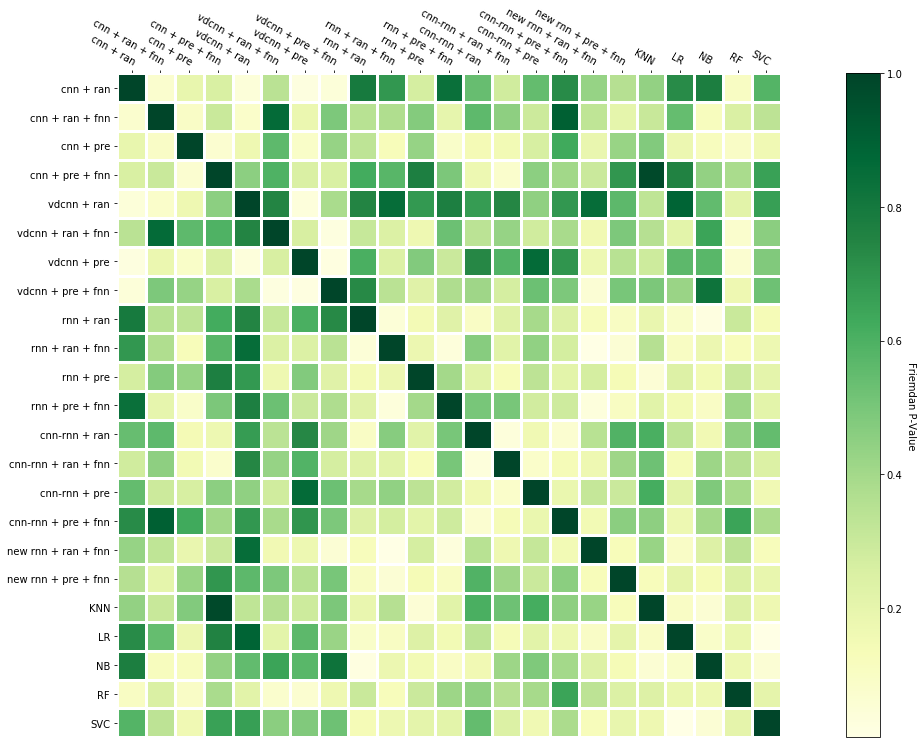

,cnn + ran,cnn + ran + fnn,cnn + pre,cnn + pre + fnn,vdcnn + ran,vdcnn + ran + fnn,vdcnn + pre,vdcnn + pre + fnn,rnn + ran,rnn + ran + fnn,rnn + pre,rnn + pre + fnn,cnn-rnn + ran,cnn-rnn + ran + fnn,cnn-rnn + pre,cnn-rnn + pre + fnn,new rnn + ran + fnn,new rnn + pre + fnn,KNN,LR,NB,RF,SVC
cnn + ran,1.000000,0.070197,0.189241,0.251794,0.038242,0.342996,0.022721,0.037677,0.792509,0.687166,0.264145,0.837937,0.538395,0.278701,0.549200,0.724778,0.430784,0.353753,0.438133,0.725360,0.773315,0.102763,0.583367
cnn + ran + fnn,0.070197,1.000000,0.093414,0.300452,0.081866,0.858351,0.178929,0.488758,0.346789,0.367861,0.473271,0.197744,0.559378,0.449135,0.291443,0.901660,0.325834,0.203242,0.301342,0.544281,0.116507,0.247347,0.334255
cnn + pre,0.189241,0.093414,1.000000,0.065873,0.165637,0.559692,0.090756,0.430641,0.330585,0.126453,0.431491,0.085029,0.145204,0.152950,0.260528,0.630164,0.186514,0.427813,0.476014,0.174565,0.115207,0.094445,0.159079
cnn + pre + fnn,0.251794,0.300452,0.065873,1.000000,0.453833,0.595075,0.246828,0.253833,0.622400,0.575722,0.767862,0.494606,0.169911,0.079555,0.453956,0.405938,0.293424,0.691097,0.981839,0.758822,0.440818,0.385553,0.656841
vdcnn + ran,0.038242,0.081866,0.165637,0.453833,1.000000,0.748263,0.033949,0.383921,0.751510,0.850011,0.683829,0.770732,0.673442,0.741033,0.447300,0.688658,0.849570,0.561692,0.326323,0.884874,0.550560,0.216616,0.665412
vdcnn + ran + fnn,0.342996,0.858351,0.559692,0.595075,0.748263,1.000000,0.258103,0.024158,0.308621,0.239872,0.166877,0.528904,0.339191,0.431411,0.279654,0.389831,0.154625,0.488026,0.351876,0.214830,0.649494,0.075101,0.458503
vdcnn + pre,0.022721,0.178929,0.090756,0.246828,0.033949,0.258103,1.000000,0.020517,0.607094,0.239611,0.477577,0.294751,0.738657,0.585687,0.857569,0.694995,0.171171,0.345296,0.285851,0.561771,0.570645,0.066475,0.482478
vdcnn + pre + fnn,0.037677,0.488758,0.430641,0.253833,0.383921,0.024158,0.020517,1.000000,0.734049,0.341015,0.226737,0.374317,0.413312,0.263713,0.529911,0.489859,0.053106,0.502308,0.494434,0.425123,0.823132,0.169004,0.523829
rnn + ran,0.792509,0.346789,0.330585,0.622400,0.751510,0.308621,0.607094,0.734049,1.000000,0.045823,0.148270,0.226349,0.096989,0.228686,0.390486,0.235989,0.119914,0.100600,0.187387,0.085963,0.018971,0.298950,0.138812
rnn + ran + fnn,0.687166,0.367861,0.126453,0.575722,0.850011,0.239872,0.239611,0.341015,0.045823,1.000000,0.175188,0.033600,0.466535,0.222669,0.444009,0.267225,0.009396,0.054574,0.354939,0.101627,0.175725,0.123905,0.170154


In [0]:
x = np.array(np_all_l)
plot_significance_matrix(friedman_test(x, clf=n_clf), clf=n_clf)
friedman_test(x, clf=n_clf)

Nemenyi-Friedman
===============
Calculate pairwise comparisons using Nemenyi post-hoc test for unreplicated blocked data.

This test is usually conducted post-hoc after significant results of the Friedman’s test. 

The statistics refer to upper quantiles of the studentized range distribution (Tukey).

**Si hay un valor MENOR DE 0'05 es SIGNIFICATIVO para el 95% OS**


In [0]:
x = np.array(np_all_l).transpose()
sp.posthoc_nemenyi_friedman(x).rename(columns=name_dict, index=name_dict)

Conover-Friedman
===============
Calculate pairwise comparisons using Conover post-hoc test for unreplicated blocked data. 

This test is usually conducted post-hoc after significant results of the Friedman test.

The statistics refer to the Student t distribution.


**SI HAY UNA DIFERENCIA MENOR DE 0'05 ES SIGNIFICATIVO PARA EL 95% DE LOS CASOS**

In [0]:
x = np.array(np_all_l).transpose()
sp.posthoc_conover_friedman(x).rename(columns=name_dict, index=name_dict)

Siegel-Friedman
=============
Siegel and Castellan’s All-Pairs Comparisons Test for Unreplicated Blocked Data.

The p-values are computed from the standard normal distribution.


**SI HAY UNA DIFERENCIA MENOR DE 0'05 ES SIGNIFICATIVO PARA EL 95% DE LOS CASOS**

In [0]:
x = np.array(np_all_l).transpose()
sp.posthoc_siegel_friedman(x).rename(columns=name_dict, index=name_dict)